
# **📌 Project Title**

**Grocery Sales Forecasting – Corporación Favorita Case Study**

# **🎯 Project Goal**

The objective of this project is to develop a predictive model that accurately forecasts daily product sales across multiple grocery stores. By leveraging historical sales data, store information, and external factors (e.g., holidays, promotions), we aim to create a robust forecasting system that can generalize well to future periods.

# **🏢 Business Context**

Corporación Favorita is one of the largest grocery store chains in Ecuador. With thousands of products and multiple store locations, predicting future sales is a critical task for managing operations efficiently. Accurate forecasts enable the company to:

•	📦 Optimize inventory — ensure products are available when customers need them while minimizing overstock.

•	🛒 Reduce waste — especially for perishable goods by aligning supply with demand.

•	💰 Improve profitability — through better pricing, promotions, and stock allocation.

•	🚚 Enhance logistics — streamline supply chain management and replenishment scheduling.

# **🌍 Real-World Application**

Sales forecasting plays a crucial role in retail and supply chain optimization. The techniques developed here are directly applicable to:

•	🏪 Retail chains managing multiple stores with varied customer demand.

•	🥦 Supermarkets & groceries aiming to cut food waste and stockouts.

•	📊 E-commerce platforms predicting order volume for better fulfillment planning.

•	🚢 Logistics companies optimizing warehouse and delivery schedules.

•	🎯 Promotional planning — aligning discounts and marketing campaigns with predicted demand peaks.

# **Importing Libraries**

In [78]:
# Install missing packages
#%pip install pandas seaborn statsmodels scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#import linear model
from sklearn.linear_model import LinearRegression

#import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# **Importing Data**

In [79]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

# setting the file path - locally.
file_path = './data_store_sales/'

## Items

In [80]:
# Load the items CSV files into pandas DataFrames
df_items = pd.read_csv(file_path+'items.csv')

print('The items shape is',df_items.shape)
print(df_items.info())
print('\nvalue_counts\n', df_items.nunique())
print('\nnull value\n',df_items.isnull().sum())
df_items.head(5)


The items shape is (4100, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.3+ KB
None

value_counts
 item_nbr      4100
family          33
class          337
perishable       2
dtype: int64

null value
 item_nbr      0
family        0
class         0
perishable    0
dtype: int64


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [81]:
df_items.groupby(['family','perishable'])['perishable'].count()

family                      perishable
AUTOMOTIVE                  0               20
BABY CARE                   0                1
BEAUTY                      0               19
BEVERAGES                   0              613
BOOKS                       0                1
BREAD/BAKERY                1              134
CELEBRATION                 0               31
CLEANING                    0              446
DAIRY                       1              242
DELI                        1               91
EGGS                        1               41
FROZEN FOODS                0               55
GROCERY I                   0             1334
GROCERY II                  0               14
HARDWARE                    0                4
HOME AND KITCHEN I          0               77
HOME AND KITCHEN II         0               45
HOME APPLIANCES             0                1
HOME CARE                   0              108
LADIESWEAR                  0               21
LAWN AND GARDEN      

In [82]:
# Filter the DataFrame for specific families (instructed in the project)
# 'GROCERY I', 'BEVERAGES', 'CLEANING'
filtered_df_items = df_items[df_items['family'].isin(['GROCERY I', 'BEVERAGES', 'CLEANING'])]
filtered_df_items

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
5,105574,GROCERY I,1045,0
...,...,...,...,...
4094,2132163,GROCERY I,1040,0
4095,2132318,GROCERY I,1002,0
4096,2132945,GROCERY I,1026,0
4097,2132957,GROCERY I,1068,0


In [83]:
filtered_df_items['perishable'].value_counts()

perishable
0    2393
Name: count, dtype: int64

In [84]:
df_items['perishable'].value_counts()

perishable
0    3114
1     986
Name: count, dtype: int64

**Item Dataset Summary** 

	•	Shape: 4,100 rows × 4 columns (item_nbr, family, class, perishable).
	•	No missing values in any column.
	•	Unique values:
	•	item_nbr: 4,100 unique product IDs.
	•	family: 33 unique product categories (e.g., grocery, beverages, etc.).
	•	class: 337 unique product sub-classes.
	•	perishable: Binary flag (0 = non-perishable and count 3114, 1 = perishable and count 986).
	•	Key insight: Dataset covers a wide range of product types and categories, with perishable and non-perishable   goods clearly identified, which is important for demand forecasting and supply chain planning. For only 3 categories of family ('GROCERY I', 'BEVERAGES', 'CLEANING'), we have only non-perishable goods (2393).

## Stores

In [85]:
# Load the stores CSV files into pandas DataFrames
df_stores = pd.read_csv(file_path+'stores.csv')
print('The store  shape is',df_stores.shape)
print(df_stores.info())
print('\nvalue_counts\n', df_stores.nunique())
print('\nnull value\n',df_stores.isnull().sum())
df_stores.head(5)

The store  shape is (54, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None

value_counts
 store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

null value
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


**Store Dataset Summary**

	•	Shape: 54 rows × 5 columns (store_nbr, city, state, type, cluster).
	•	No missing values in any column.
	•	Unique values:
	•	store_nbr: 54 unique store IDs.
	•	city: 22 unique cities.
	•	state: 16 unique states.
	•	type: 5 store types.
	•	cluster: 17 store clusters (groups with similar characteristics).
	•	Key insight: This dataset provides geographic (city, state) and operational (type, cluster) context for each store, which is useful for modeling regional demand variations and tailoring inventory strategies.

In [86]:
df_stores['city'].value_counts()

city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: count, dtype: int64

In [87]:
# Grouping df_stores by state and city
grouped_stores = df_stores.groupby(['state', 'city']).size().reset_index(name='store_count')

# Display the grouped dataset
print(grouped_stores)

                             state           city  store_count
0                            Azuay         Cuenca            3
1                          Bolivar       Guaranda            1
2                       Chimborazo       Riobamba            1
3                         Cotopaxi      Latacunga            2
4                           El Oro        Machala            2
5                       Esmeraldas     Esmeraldas            1
6                           Guayas          Daule            1
7                           Guayas      Guayaquil            8
8                           Guayas       Libertad            1
9                           Guayas         Playas            1
10                        Imbabura         Ibarra            1
11                            Loja           Loja            1
12                        Los Rios       Babahoyo            1
13                        Los Rios        Quevedo            1
14                          Manabi      El Carmen      

**We are going to apply forecast model and data analysis for stores in 'Guayas' state and items family of 'GROCERY I', 'BEVERAGES', & 'CLEANING'**

In [88]:
df_store_Guayas= df_stores[df_stores['state']=='Guayas']
print('The items shape is',df_store_Guayas.shape)
df_store_Guayas



The items shape is (11, 5)


,store_nbr,city,state,type,cluster
23,24,Guayaquil,Guayas,D,1
25,26,Guayaquil,Guayas,D,10
26,27,Daule,Guayas,D,1
27,28,Guayaquil,Guayas,E,10
28,29,Guayaquil,Guayas,E,10
29,30,Guayaquil,Guayas,C,3
31,32,Guayaquil,Guayas,C,3
33,34,Guayaquil,Guayas,B,6
34,35,Playas,Guayas,C,3
35,36,Libertad,Guayas,E,10


**Store Data (Sample) – Guayas Region Summary**

	•	Geographic focus: All stores (11 unique) in this sample are located in the Guayas state of Ecuador.
	•	Cities covered: Guayaquil (multiple entries), Daule, Playas, Libertad.
	•	Store types present: A, B, C, D, E — indicating different formats or business models.
	•	Clusters: Stores belong to multiple clusters (e.g., 1, 3, 6, 10, 17), representing groups with similar sales or operational characteristics.
	•	Observation:
	•	Guayaquil hosts the majority of stores in this subset, with diverse 5 store types and 5 unique clusters.
	•	Cluster 10 and 3 appear frequently, suggesting common operational patterns in this region.
	•	Variety in store type and cluster within the same city may indicate differentiated customer segments or neighborhood-specific strategies.

In [89]:
df_stores[df_stores['state']=='Pichincha']

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15
10,11,Cayambe,Pichincha,B,6


In [90]:
store_nbr_list_guayas = df_store_Guayas['store_nbr'].tolist()
store_nbr_list_guayas

[24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 51]

## Transactions

In [91]:
# Load the transactions CSV files into pandas DataFrames
df_transactions = pd.read_csv(file_path+'transactions.csv')
print('The itetransaction shape is',df_transactions.shape)
print(df_transactions.info())
print('\nvalue_counts\n', df_transactions.nunique())
print('\nnull value\n',df_transactions.isnull().sum())
df_transactions.head(5)


The itetransaction shape is (83488, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None

value_counts
 date            1682
store_nbr         54
transactions    4993
dtype: int64

null value
 date            0
store_nbr       0
transactions    0
dtype: int64


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


**Transactions Dataset Summary**

	•	Shape: 83,488 rows × 3 columns.
	•	Columns:
	1.	date – Transaction date (covers 1,682 unique dates).
	2.	store_nbr – Store number (54 unique stores).
	3.	transactions – Number of transactions recorded on that date for the store (ranges across 4,993 unique transaction counts).
	•	Data Quality: No missing values in any column.
	•	Sample Observation:
	•	On 2013-01-01, store 25 had 770 transactions.
	•	Insights:
	•	Data provides a daily transactional footprint for each store.
	•	Useful for identifying sales patterns, seasonal trends, and store performance over time.
	•	Can be merged with sales and store metadata to explore correlations between store type, location, and transaction volumes.

In [92]:
print('store number in Guayas\n',store_nbr_list_guayas)

df_transactions_guayas = df_transactions[df_transactions['store_nbr'].isin(store_nbr_list_guayas)]
df_transactions_guayas['date'] = pd.to_datetime(df_transactions_guayas['date'])
df_transactions_guayas

store number in Guayas
 [24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 51]


/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_23023/3960584851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transactions_guayas['date'] = pd.to_datetime(df_transactions_guayas['date'])


,date,store_nbr,transactions
21,2013-01-02,24,2605
23,2013-01-02,26,1008
24,2013-01-02,27,1386
25,2013-01-02,28,950
26,2013-01-02,30,708
...,...,...,...
83465,2017-08-15,32,615
83467,2017-08-15,34,2007
83468,2017-08-15,35,612
83469,2017-08-15,36,1192


**From transaction dataset in Guayas, there are 17397 dates. for example on 2013-01-02, at store_nbr 24, the total transactions were 2605.**

In [93]:
df_transactions_guayas.isnull().sum()


date            0
store_nbr       0
transactions    0
dtype: int64

In [94]:
df_transactions.groupby('store_nbr')['transactions'].sum().sort_values(ascending=False).head(10)

store_nbr
44    7273093
47    6535810
45    6201115
46    5990113
3     5366350
48    5107785
8     4637971
49    4574103
50    4384444
11    3972488
Name: transactions, dtype: int64

## Oil

In [95]:
# Load the oil CSV files into pandas DataFrames
df_oil = pd.read_csv(file_path+'oil.csv')
print('The oil shape is',df_oil.shape)
print('\nThe info\n',df_oil.info())
print('\nvalue_counts\n', df_oil.nunique())
print('\nnull value\n',df_oil.isnull().sum())
print('\nduploicates\n',df_oil.duplicated().sum())

df_oil.head(5)

The oil shape is (1218, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB

The info
 None

value_counts
 date          1218
dcoilwtico     998
dtype: int64

null value
 date           0
dcoilwtico    43
dtype: int64

duploicates
 0


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


**Oil Prices Dataset Summary**

	•	Shape: 1,218 rows × 2 columns.
	•	Columns:

	1.	date – Daily observation date (no missing values).
	2.	dcoilwtico – Daily West Texas Intermediate (WTI) crude oil price (USD per barrel).
    
	•	Data Quality:
	•	43 missing values in dcoilwtico.
	•	No duplicates in the dataset.
	•	Value Counts:
	•	1,218 unique dates.
	•	998 unique oil price values.
	•	Example Entries:
	•	2013-01-02 → $93.14
	•	2013-01-03 → $92.97
	•	Usage:
	•	Oil prices may influence transportation and product costs, impacting grocery sales forecasts.

In [96]:

print('The date range is',df_oil['date'].min(), 'to', df_oil['date'].max())
print(len(df_oil['date'].unique()))

The date range is 2013-01-01 to 2017-08-31
1218


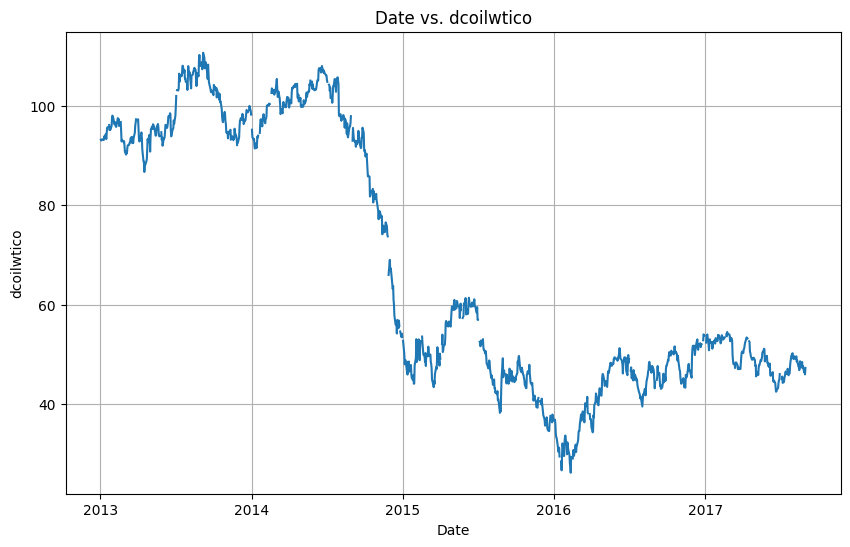

In [97]:
# plot date vs dcoilwtico from oil dataset

import pandas as pd
import matplotlib.pyplot as plt
# Convert the 'date' column to datetime objects
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_oil['date'], df_oil['dcoilwtico'])
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.title('Date vs. dcoilwtico')
plt.grid(True)
plt.show()


**Oil Price Trend Summary (2013–2017)**

	•	WTI crude oil prices started above $90/barrel in 2013 and peaked above $105 in 2014.
	•	From mid-2014 to early 2016, prices experienced a sharp decline, dropping to below $30 — the lowest point in the period.
	•	After early 2016, prices partially recovered, fluctuating between $40–$55 until 2017.
	•	This volatility could have impacted transportation costs, product prices, and consumer purchasing behavior in the grocery sector.

## Holidays Event

In [98]:
# Load the holiday_events CSV files into pandas DataFrames
df_holiday = pd.read_csv(file_path+'holidays_events.csv')
print('The holiday shape is',df_holiday.shape)
print(df_holiday.info())
print('\nvalue_counts\n', df_holiday.nunique())
print('\nnull value\n',df_holiday.isnull().sum())
df_holiday.head(5)

The holiday shape is (350, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None

value_counts
 date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

null value
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


**Holiday Dataset Summary**

	•	Shape: 350 rows × 6 columns
	•	Purpose: Contains holiday information, including date, type, and location.
	•	Columns:
	•	date: Holiday date (350 unique, some repeated for different locations).
	•	type: 6 categories (e.g., National, Regional, Local).
	•	locale: 3 levels (National, Regional, Local).
	•	locale_name: 24 unique location names.
	•	description: 103 unique holiday/event names.
	•	transferred: Boolean indicating if the holiday was moved to another date.
	•	Data Quality: No missing values; transferred has 2 unique values (True/False).

This dataset is useful for identifying sales patterns around holidays, differentiating between national and local impacts, and adjusting forecasting models for special events.

**holidays_events.csv**

1. Holidays and Events, with metadata

2. Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

3. NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.0

In [99]:

print(df_holiday['locale_name'].value_counts())
print(df_holiday['locale'].value_counts())

locale_name
Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                       6
Machala                             6
Imbabura                            6
Puyo                                6
Libertad                            6
Cayambe                             6
Name: count, dtype: int64
locale
National    174
Local       152
Regional   

In [100]:
df_holiday.duplicated().sum()

np.int64(0)

In [101]:
df_holiday[df_holiday['type']=='Event']

,date,type,locale,locale_name,description,transferred
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False
103,2014-05-11,Event,National,Ecuador,Dia de la Madre,False
106,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False
107,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False
108,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False
114,2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
115,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
116,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
117,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False


In [102]:
national= df_holiday[df_holiday['locale']=='National']
print(national['locale_name'].value_counts())
national

locale_name
Ecuador    174
Name: count, dtype: int64


,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [103]:
df_holiday[df_holiday['locale']=='Local']

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
...,...,...,...,...,...,...
339,2017-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
340,2017-12-06,Holiday,Local,Quito,Fundacion de Quito,True
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False


In [104]:
df_holiday[df_holiday['locale']=='Regional']

,date,type,locale,locale_name,description,transferred
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
23,2012-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False
24,2012-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
47,2013-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
58,2013-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
76,2013-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False
77,2013-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
96,2014-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
112,2014-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False


In [105]:
df_holiday[df_holiday['date']=='2013-01-05']

,date,type,locale,locale_name,description,transferred
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False


In [106]:
local_filtered = df_holiday[df_holiday['locale'].isin(['Local', 'National'])]
local_filtered

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [107]:
print(df_holiday['transferred'].value_counts())
df_holiday[df_holiday['transferred']==True]

transferred
False    338
True      12
Name: count, dtype: int64


,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [108]:
df_holiday[df_holiday['type']=='Transfer']

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [109]:
df_holiday[df_holiday['type']=='Additional'].head(5)

,date,type,locale,locale_name,description,transferred
28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False


In [110]:
df_holiday['type'].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [111]:
df_holiday[(df_holiday['type'] == 'Bridge') | (df_holiday['type'] == 'Work Day')]

,date,type,locale,locale_name,description,transferred
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
277,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


In [112]:
df_holiday[df_holiday['type']=='Event'].head(5)

,date,type,locale,locale_name,description,transferred
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False
103,2014-05-11,Event,National,Ecuador,Dia de la Madre,False
106,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False
107,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False
108,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False


In [113]:
# Create the 'is_holiday' column based on the given conditions
df_holiday['is_holiday'] = (
    ((df_holiday['type'] == 'Holiday') & (df_holiday['transferred'] == False)) |
    (df_holiday['type'].isin(['Additional', 'Bridge', 'Transfer']))
).astype(int)
df_holiday['is_event']=df_holiday['type'].apply(lambda x: 1 if x == 'Event' else 0) 
df_holiday

,date,type,locale,locale_name,description,transferred,is_holiday,is_event
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1,0
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1,0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1,0
...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1,0
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1,0
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1,0
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1,0


**Holiday & Event Feature Engineering Summary**

In this step, two new binary features were created from the holidays_events.csv dataset to make the data more useful for modeling:

1.	is_holiday

	•	Set to 1 if the day is a true holiday (type = Holiday and transferred = False) or if it belongs to Additional, Bridge, or Transfer categories.

	•	Helps the model easily identify actual or extended holidays without parsing multiple holiday types.

2.	is_event

	•	Set to 1 if the type is Event.

	•	Useful for capturing spikes or dips in sales due to special events.

✅ This preprocessing step simplifies holiday/event detection and ensures that transferred days are not mistakenly treated as actual holidays, which improves sales forecast accuracy.

In [114]:
df_holiday[(df_holiday['type']=='Event') | (df_holiday['type']=='Work Day')]

,date,type,locale,locale_name,description,transferred,is_holiday,is_event
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False,0,0
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False,0,0
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False,0,1
103,2014-05-11,Event,National,Ecuador,Dia de la Madre,False,0,1
106,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False,0,1
...,...,...,...,...,...,...,...,...
254,2016-05-16,Event,National,Ecuador,Terremoto Manabi+30,False,0,1
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False,0,0
284,2016-11-25,Event,National,Ecuador,Black Friday,False,0,1
285,2016-11-28,Event,National,Ecuador,Cyber Monday,False,0,1


In [115]:
city_guayas=df_store_Guayas['city'].unique().tolist()
city_guayas

['Guayaquil', 'Daule', 'Playas', 'Libertad']

In [116]:
filtered_holidays_guayas = df_holiday[df_holiday['locale_name'].isin(['Guayaquil', 'Daule', 'Playas', 'Libertad', 'Ecuador'])]
filtered_holidays_guayas

,date,type,locale,locale_name,description,transferred,is_holiday,is_event
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,1,0
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,0,0
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,1,0
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False,1,0
...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1,0
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1,0
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1,0
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1,0


In [117]:
print(filtered_holidays_guayas['is_holiday'].value_counts())
print(filtered_holidays_guayas['is_event'].value_counts())

is_holiday
1    121
0     70
Name: count, dtype: int64
is_event
0    135
1     56
Name: count, dtype: int64


**Guayas State Holidays & Events Summary**

After filtering for the Guayas state and applying the new is_holiday and is_event features:

	•	Holidays (is_holiday = 1): 121 days
	•	Non-holidays (is_holiday = 0): 70 days
	•	Events (is_event = 1): 56 days
	•	Non-events (is_event = 0): 135 days

📌 This breakdown provides a clear picture of special dates in Guayas, which is essential for analyzing seasonal sales patterns and forecasting demand more accurately.

**Additional Notes**

1. Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

2. A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## Train

In [118]:
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv(file_path+'train.csv', nrows=2e6)
print('The train shape is',df_train.shape)
print(df_train.info())
print('\n value_counts \n', df_train.nunique())
print(' null value \n',df_train.isnull().sum())
df_train.head(5)

The train shape is (2000000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 91.6+ MB
None

 value_counts 
 id             2000000
date                50
store_nbr           46
item_nbr          1625
unit_sales       33764
onpromotion          0
dtype: int64
 null value 
 id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2000000
dtype: int64


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


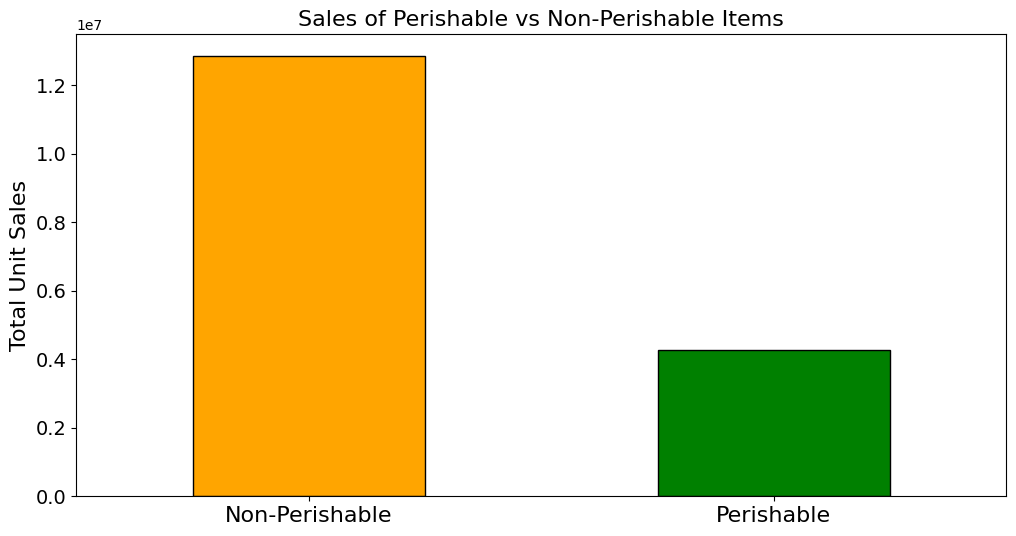

In [119]:
# Merging df_train with items to get perishable data
df_train_items = pd.merge(df_train, df_items, on='item_nbr', how='left')
df_train_items['perishable'] = df_train_items['perishable'].astype(bool)
# Aggregating sales by perishable and non-perishable items
perishable_sales = df_train_items.groupby('perishable')['unit_sales'].sum()

# Plotting sales for perishable and non-perishable items
plt.figure(figsize=(12,6))
perishable_sales.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title('Sales of Perishable vs Non-Perishable Items', fontsize=16)
plt.ylabel('Total Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(
    ticks=[0, 1], 
    labels=['Non-Perishable', 'Perishable'], 
    fontsize=16, 
    rotation=0  # Keep x-axis labels horizontal
)
plt.yticks(fontsize=14)
plt.show()

**Train Dataset Summary & Analysis**
	•	Shape: (2,000,000, 6) → 2 million rows and 6 columns.
	•	Columns:

	 1.	id (int64) – Unique row identifier.
	 2.	date (object) – Transaction date (50 unique dates in this sample).
	 3.	store_nbr (int64) – Store ID (46 unique stores).
	 4.	item_nbr (int64) – Item ID (1,625 unique items).
	 5.	unit_sales (float64) – Number of units sold (33,764 unique values).
	 6.	onpromotion (float64) – Indicates if the item was on promotion (all values missing in this subset).

	•	Memory Usage: ~91.6 MB.

	•	Value Counts:
	•	store_nbr: 46 unique stores present.
	•	item_nbr: 1,625 unique products.
	•	date: 50 unique days in this subset.
	•	onpromotion: Missing (NaN) in all 2M rows (likely needs separate joining with promotion data).

	•	Null Values:
	•	onpromotion: 100% missing.
	•	All other columns: 0 missing values.

	•	Example Rows:
	•	Store 25, on 2013-01-01, sold multiple items (unit_sales ranging from 1 to 7).
	•	onpromotion values are NaN, meaning this dataset might rely on other sources for promotion information.

📌 Insights:

	•	This dataset is sales-focused, with unit_sales as the key target for forecasting.
	•	Missing onpromotion data in this batch suggests either preprocessing is needed or merging with another dataset.
	•	date has multiple entries per day for different store-item combinations, confirming it’s a time series panel data structure (store × item × date).

## **Filtering train data for state (Guayas) and only for top 3 families based on items counts**

In [51]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv(file_path+'train.csv', chunksize=chunk_size):
    #print(chunk)
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks


/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_23023/2766939774.py:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path+'train.csv', chunksize=chunk_size):


In [52]:
# unique store id for Guayas state
store_ids

array([24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 51])

In [53]:
print('df_train shape',df_train.shape)
df_train.head(5)

df_train shape (22941656, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18789,2013-01-02,24,103665,6.0,NaN
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN


In [54]:
print( df_train.info())
print('value_counts\n', df_train.nunique())
print('null value\n',df_train.isnull().sum())
print('unique value\n',df_train.nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22941656 entries, 0 to 22941655
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.0+ GB
None
value_counts
 id             22941656
date               1680
store_nbr            11
item_nbr           4008
unit_sales       109203
onpromotion           2
dtype: int64
null value
 id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    3980341
dtype: int64
unique value
 id             22941656
date               1680
store_nbr            11
item_nbr           4008
unit_sales       109203
onpromotion           2
dtype: int64


In [55]:
df_train['onpromotion'].value_counts()

onpromotion
False    17446666
True      1514649
Name: count, dtype: int64

**Filtered Train Dataset (Guayas State) – Summary**

	•	Shape: 22,941,656 rows × 6 columns.
	•	Period: 1,680 unique dates.
	•	Stores: 11 unique stores from Guayas.
	•	Items: 4,008 unique products.
	•	Sales: 109,203 unique unit_sales values.
	•	Promotions:
	•	True: 1,514,649 entries (~6.6%)
	•	False: 17,446,666 entries (~76.1%)
	•	Missing: 3,980,341 entries (~17.3%).
	•	Nulls: Only onpromotion has missing values; all other columns are complete.

This subset contains time series sales data for Guayas stores, with product-level granularity and promotion status information.

In [56]:
# Plotting the number of items per family (for top 3 families only)
# Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
#print(items_per_family)
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families
top_3_families

,Family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


**Even after filtering, the dataset remains quite large. To avoid potential crashes during processing, we’ll narrow it down to only the top 3 product families by item count. But first, let’s identify these top 3 families:**

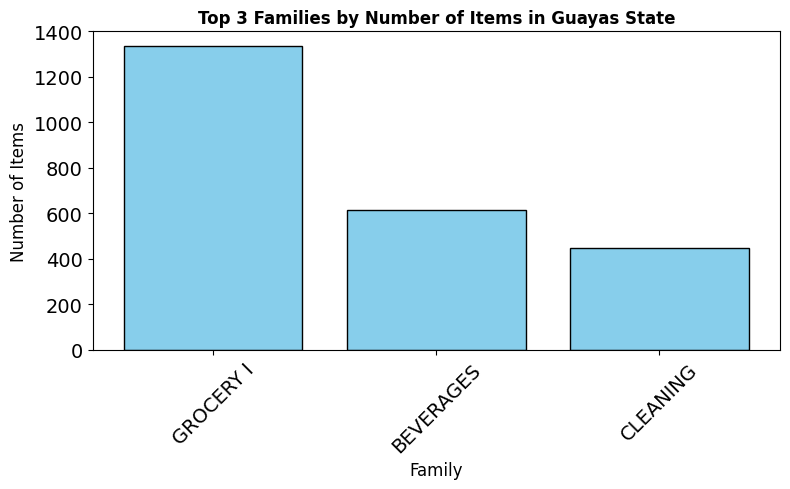

In [57]:
# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items in Guayas State", fontsize=12, fontweight='bold')
plt.xlabel("Family", fontsize=12)
plt.ylabel("Number of Items", fontsize=12)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

In [58]:
# Now we filter our train data based on top 3 family items count
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
print(len(item_ids))
df_train = df_train[df_train['item_nbr'].isin(item_ids)]
print(df_train.shape) # shape reduced from (22941656, 6) to (14745768, 6)
df_train.head(5)

2393
(14745768, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN
5,18794,2013-01-02,24,105737,17.0,NaN


In [59]:
print(df_train.isnull().sum())
# Check for duplicates
duplicates = df_train.duplicated().sum()
print(f"Number of duplicate rows\n: {duplicates}")
print(df_train['onpromotion'].value_counts())

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64
Number of duplicate rows
: 0
onpromotion
False    11319196
True       679297
Name: count, dtype: int64


In [60]:
df_train_2013_01_02 = df_train[(df_train['store_nbr'] == 24) & (df_train['date'] == '2013-01-02')]
df_train_2013_01_02

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,NaN
2,18791,2013-01-02,24,105575,2.0,NaN
3,18792,2013-01-02,24,105577,1.0,NaN
4,18793,2013-01-02,24,105693,7.0,NaN
5,18794,2013-01-02,24,105737,17.0,NaN
...,...,...,...,...,...,...
1014,19803,2013-01-02,24,1109326,10.0,NaN
1015,19804,2013-01-02,24,1109389,1.0,NaN
1016,19805,2013-01-02,24,1109390,1.0,NaN
1017,19806,2013-01-02,24,1109391,1.0,NaN


In [61]:
# checking unique dates in the train dataset
unique_dates = df_train['date'].unique()
len(unique_dates)


1680

In [62]:
# checking for zero and negative sales in the train dataset
# Check for zero sales
zero_sales_train=df_train[df_train['unit_sales']==0]
print('zero sales in train',len(zero_sales_train))
# Check for negative sales
negative_sales_train=df_train[df_train['unit_sales']<0]
print('negative sales in train',len(negative_sales_train))

zero sales in train 0
negative sales in train 794


**Plan for Preprocessing before applying Model**

1. Check for missing values
2. Check for outliers
3. Handle negative sales
4. Filling missing dates with zero sales
4. Feature Engineering
   1. Time-based features
   2. Rolling / Expanding window
   3. EDA based new features
5. EDA
   1. Visual EDA
   2. Analyse monthly sales
   3. Analyse holiday impact on sales
   4. Oil price impact on sales
   5. Analysing perishable items
   6. and more

# **Preprocessing**

## **1. Dealing with missing values**

In [63]:
# Checking missing values in train
df_train.isnull().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64

**no null value in train data set**

In [64]:
# Focusing on missing values in the 'onpromotion' column in train
# Filling missing values in 'onpromotion' column with False and then converting to int
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)
df_train['onpromotion'] = df_train['onpromotion'].astype(int)


/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_23023/722778184.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


In [65]:
# Checking the value counts of 'onpromotion' column in train dataset
print('onpromotion value counts in train dataset:')
df_train['onpromotion'].value_counts()

onpromotion value counts in train dataset:


onpromotion
0    14066471
1      679297
Name: count, dtype: int64

**count of on promotion is 679297 and no promotion 14066471 (after dealing missing values).**

In [66]:
df_train.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,18790,2013-01-02,24,105574,12.0,0
2,18791,2013-01-02,24,105575,2.0,0
3,18792,2013-01-02,24,105577,1.0,0
4,18793,2013-01-02,24,105693,7.0,0
5,18794,2013-01-02,24,105737,17.0,0


In [67]:
# Filling null value using linear interpolation  method for oil price in oil dataset
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear', limit_direction='both')
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

**missing oil price is filled with linear interpolation method**

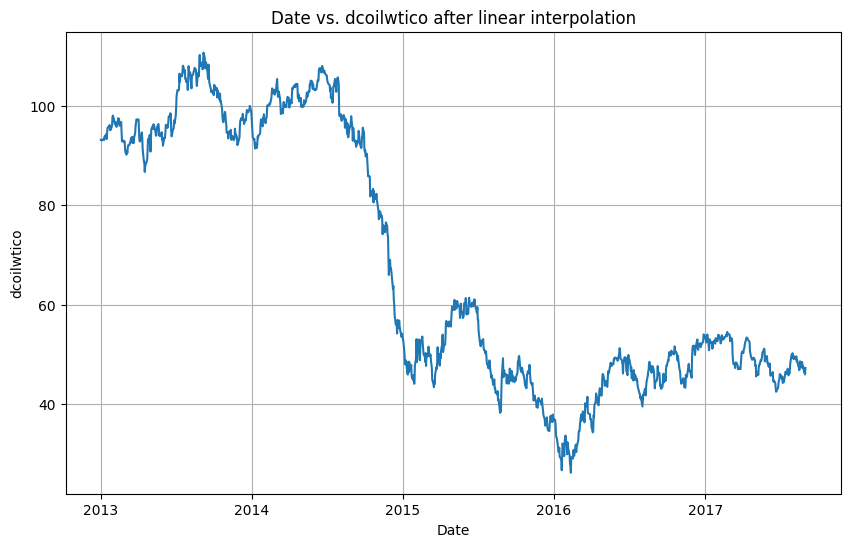

In [68]:
# prompt: plot date vs dcoilwtico from oil dataset

import pandas as pd
import matplotlib.pyplot as plt
# Convert the 'date' column to datetime objects
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_oil['date'], df_oil['dcoilwtico'])
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.title('Date vs. dcoilwtico after linear interpolation')
plt.grid(True)
plt.show()


**The plot shows** daily oil prices (dcoilwtico) after applying linear interpolation to fill missing values. The trend highlights a sharp decline from above $100 in 2014 to below $40 in early 2016, followed by partial recovery and stabilization between $45–$55 until 2017.

## **2. Converting Negative Sales to zero**

In [69]:
# Checking for negative sales (items returns to store)
negative_sales = df_train[df_train['unit_sales'] < 0]
print('The number of negative sales is',len(negative_sales))
print(negative_sales.shape)
negative_sales.head()  # Viewing negative sales for analysis

The number of negative sales is 794
(794, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,0
54236,309805,2013-01-09,35,1079215,-8.0,0
64452,382905,2013-01-11,27,1097187,-20.0,0
96414,564108,2013-01-15,51,627885,-36.0,0
132903,787522,2013-01-21,24,211205,-5.0,0


In [73]:
# Replace negative 'unit_sales' values with 0
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: 0 if x < 0 else x)
df_train[df_train['unit_sales'] < 0]


,id,date,store_nbr,item_nbr,unit_sales,onpromotion


In [ ]:
df_train[df_train['unit_sales'] == 0]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,0.0,0
54236,309805,2013-01-09,35,1079215,0.0,0
64452,382905,2013-01-11,27,1097187,0.0,0
96414,564108,2013-01-15,51,627885,0.0,0
132903,787522,2013-01-21,24,211205,0.0,0
...,...,...,...,...,...,...
22823662,124830870,2017-08-09,32,258395,0.0,0
22830152,124870543,2017-08-09,51,1354711,0.0,0
22830326,124870717,2017-08-09,51,1463602,0.0,0
22887719,125230016,2017-08-13,24,2010786,0.0,0


In [ ]:
print('no of unique store',df_train['store_nbr'].nunique())
print('no of uniques items',df_train['item_nbr'].nunique())

no of unique store 11
no of uniques items 2323


In [ ]:
import pandas as pd

# Ensure date column is in datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Create a complete date range from min to max date in the dataset
full_date_range = pd.date_range(start=df_train['date'].min(), end=df_train['date'].max())

# Find missing dates in df_train
missing_dates = full_date_range.difference(df_train['date'].unique())

print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-01-01', '2015-12-25',
               '2016-01-01', '2016-12-25', '2017-01-01'],
              dtype='datetime64[ns]', freq=None)


**On these missing dates the stores were closed hence no sales, which we will adjust later by including those dates with zero sales in the df_train dataset**

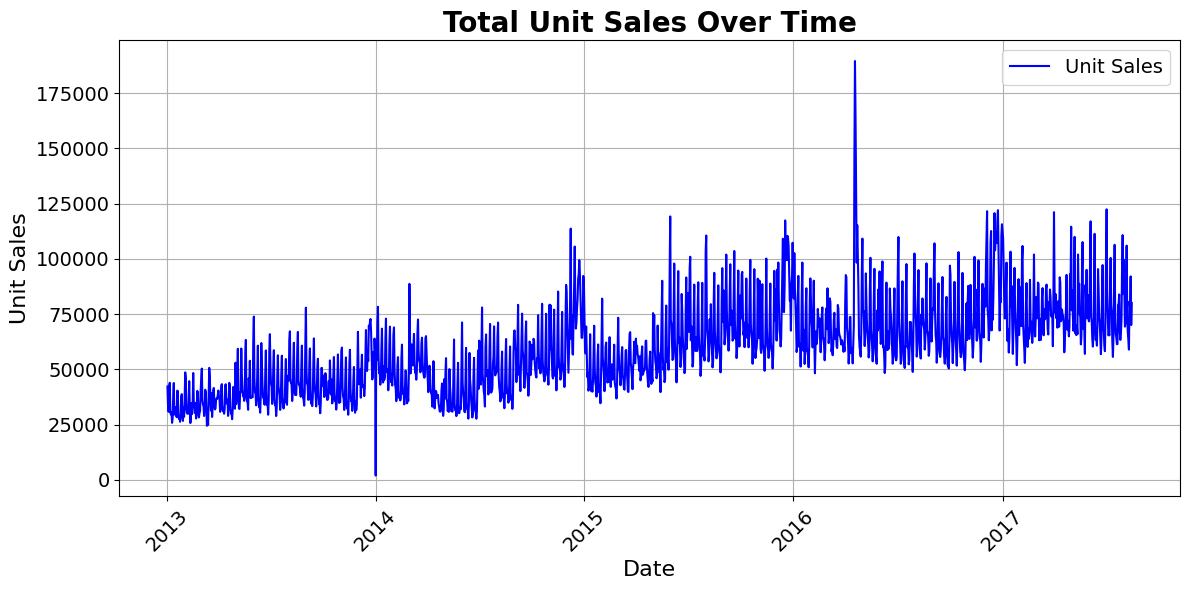

In [ ]:
# Aggregating total unit_sales by date
df_train_= df_train.copy()
df_train_['date'] = pd.to_datetime(df_train_['date'])
sales_by_date = df_train_.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date.index, sales_by_date.values, label='Unit Sales', color='blue')
plt.title('Total Unit Sales Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

**The chart (unit sales vs over time) shows** total unit sales increasing steadily from 2013 to 2017, with noticeable seasonal fluctuations and sharp spikes around late 2015–2016, due to natural disaster.

**Additional Notes**

1. Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

2. A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## **3. Outlier Analysis**

**Extremely high sales**

Another type of outlier could be extremely high sales for certain items or stores on specific days. These may be anomalies due to special events, promotions, or data errors. We can identify outliers by looking at sales values that are far higher than the typical sales distribution for a store or item. Often this can be measured with Z-score.

**A Z-score** (or standard score) is a statistical measurement that describes how many standard deviations a data point is from the mean of the dataset. It is a way to standardize data and make it comparable by converting different values to a common scale. Z-scores are often used to detect outliers and understand the relative position of a data point within a distribution.

In [ ]:
# group by store_nbr and item_nbr in train dataset

# Group by 'store_nbr' and 'item_nbr'
grouped_train = df_train.groupby(['store_nbr', 'item_nbr'])

# Example: Calculate the total sum of 'unit_sales' for each store_nbr - item_nbr combination
# Example: Calculate the sum of 'unit_sales' for each group
sales_mean = grouped_train['unit_sales'].mean()
sales_mean

# 11 unique store_nbr

store_nbr  item_nbr
24         96995        1.918552
           99197        2.138462
           103520       4.683254
           105574      11.045609
           105575       8.413910
                         ...    
51         2123727      1.500000
           2123750      3.000000
           2123775      1.000000
           2123791      1.000000
           2127114      5.625000
Name: unit_sales, Length: 20788, dtype: float64

In [ ]:
# Function to calculate Z-score to detect outlier for each group (store-item combination)
def calculate_zscore_store_item(group):
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()
    # Calculate Z-score (avoiding division by zero for standard deviation)

    group['z_scores'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales !=0 else 1)
    return group

In [ ]:
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_zscore_store_item)

df_train_grouped.reset_index(drop=True, inplace=True)
print('The shape of df_train_grouped is',df_train_grouped.shape)
df_train_grouped.head(5)

The shape of df_train_grouped is (14745768, 7)


/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_22795/3795551642.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_zscore_store_item)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_scores
0,302230,2013-01-09,24,96995,2.0,0,0.053571
1,419989,2013-01-12,24,96995,2.0,0,0.053571
2,582436,2013-01-16,24,96995,1.0,0,-0.604164
3,622071,2013-01-17,24,96995,2.0,0,0.053571
4,745650,2013-01-20,24,96995,3.0,0,0.711307


In [ ]:
# Create the 'outlier' column based on the value of z_scores
# Put outlier=1 when z_scores > 5 else outlier=0

df_train_grouped['outlier'] = df_train_grouped['z_scores'].apply(lambda x: 1 if x > 5 else 0)
#df_train_grouped[df_train_grouped['date']=='2013-01-02']
df_train_grouped.tail(100)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_scores,outlier
14745668,125285393,2017-08-13,51,2113343,1.0,0,-0.729963,0
14745669,125388717,2017-08-14,51,2113343,2.0,0,-0.128817,0
14745670,125491516,2017-08-15,51,2113343,2.0,0,-0.128817,0
14745671,121624011,2017-07-09,51,2113914,1.0,0,-0.774781,0
14745672,121729261,2017-07-10,51,2113914,5.0,0,0.285446,0
...,...,...,...,...,...,...,...,...
14745763,123290860,2017-07-25,51,2127114,1.0,0,-0.669682,0
14745764,123591167,2017-07-28,51,2127114,1.0,0,-0.669682,0
14745765,123920245,2017-07-31,51,2127114,1.0,0,-0.669682,0
14745766,124029594,2017-08-01,51,2127114,5.0,1,-0.090498,0


In [ ]:
print(df_train_grouped['z_scores'].max())
print(df_train_grouped['z_scores'].min())
print(df_train_grouped['z_scores'].mean())
print(df_train_grouped['z_scores'].std())


40.23344517827156
-3.3269454779378824
-7.187015280242966e-19
0.9992736931847017


In [ ]:
# Check for null values in df_train_grouped
print('null value\n', df_train_grouped.isnull().sum())
# Check for duplicates
duplicates = df_train_grouped.duplicated().sum()
print(f"Number of duplicate rows\n: {duplicates}")
print('unique count\n', df_train_grouped.nunique())
print('zero sales\n',len(df_train_grouped[df_train_grouped['unit_sales']==0]))

null value
 id              0
date            0
store_nbr       0
item_nbr        0
unit_sales      0
onpromotion     0
z_scores       85
outlier         0
dtype: int64
Number of duplicate rows
: 0
unique count
 id             14745768
date               1680
store_nbr            11
item_nbr           2323
unit_sales         4467
onpromotion           2
z_scores         461870
outlier               2
dtype: int64
zero sales
 794


In [ ]:
# Filter rows where 'z_scores' is NaN
null_z_scores_df = df_train_grouped[df_train_grouped['z_scores'].isnull()]

# Display the filtered dataset
null_z_scores_df

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_scores,outlier
60659,41761946,2015-02-24,24,155499,1.0,0,NaN,0
152905,341143,2013-01-10,24,220432,1.0,0,NaN,0
350042,113578980,2017-04-25,24,368270,1.0,0,NaN,0
426168,5525699,2013-05-13,24,454414,0.0,0,NaN,0
447629,90575957,2016-09-10,24,464112,1.0,0,NaN,0
...,...,...,...,...,...,...,...,...
14745733,125388721,2017-08-14,51,2120723,1.0,0,NaN,0
14745748,125285395,2017-08-13,51,2122676,1.0,0,NaN,0
14745757,125491521,2017-08-15,51,2123750,3.0,0,NaN,0
14745758,125491522,2017-08-15,51,2123775,1.0,0,NaN,0


In [ ]:
# Define threshold for outliers (unit_sales) (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_scores'] > 5]
print('The number of outliers is', len(outliers))
print('The outliers shape is',outliers.shape)
outliers.head(5) # 48485 rows × 7 columns

The number of outliers is 48485
The outliers shape is (48485, 8)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_scores,outlier
188,15666702,2013-12-18,24,96995,14.0,0,7.946399,1
286,59775862,2015-10-20,24,99197,14.0,0,5.822016,1
289,60322807,2015-10-26,24,99197,19.0,0,8.276173,1
721,15717753,2013-12-19,24,103520,27.0,0,6.642670,1
770,18886543,2014-02-13,24,103520,22.0,0,5.154400,1


In [ ]:
print('null value\n', outliers.isnull().sum())
# Check for duplicates
duplicates = outliers.duplicated().sum()
print(f"Number of duplicate rows\n: {duplicates}")
print('unique count\n', outliers.nunique())
print('zero sales\n',len(outliers[outliers['unit_sales']==0]))

null value
 id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
z_scores       0
outlier        0
dtype: int64
Number of duplicate rows
: 0
unique count
 id             48485
date            1679
store_nbr         11
item_nbr        2199
unit_sales      1004
onpromotion        2
z_scores       42329
outlier            1
dtype: int64
zero sales
 0


## **4. Fill missing dates with zero sales**

In [ ]:
import pandas as pd
# Analysis of Missing dates in the train dataset
# Ensure date column is in datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Create a complete date range from min to max date in the dataset
full_date_range = pd.date_range(start=df_train['date'].min(), end=df_train['date'].max())

# Find missing dates in df_train
missing_dates = full_date_range.difference(df_train['date'].unique())

print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-01-01', '2015-12-25',
               '2016-01-01', '2016-12-25', '2017-01-01'],
              dtype='datetime64[ns]', freq=None)


The dataset is missing sales records for major public holidays, specifically:

	•	Christmas Day — December 25 for 2013, 2014, 2015, 2016
	•	New Year’s Day — January 1 for 2015, 2016, 2017

These gaps likely reflect store closures during national holidays rather than missing data errors.

☝🏼
**Time-series models** expect a complete calendar. If a day is skipped entirely, the model can’t tell whether the gap means “zero sold” or “data lost”. Filling those gaps with explicit zeros keeps the story straight and prevents hard-to-debug errors later on.

**Here's why it's important to fill in missing dates with 0 sales:**

**Consistency in Time Steps:**

Time-series models expect an unbroken calendar. If certain dates are missing, the model may incorrectly assume that these missing dates indicate meaningful patterns (e.g., holidays or trends) instead of simply being gaps in the data.

**Accurate Representation of Sales Patterns:**

A zero is a real signal: “we were open, but nothing sold.” Leaving the row out hides that fact and can inflate average-sales figures.

**Avoiding Data Misalignment:**

Soon we’ll add lag features (a new column that copies “sales 7 days ago”) and rolling statistics (e.g., 30-day moving average). Both slide along the date index. Missing days break those sliding windows and shift the numbers out of sync.
Lag features and Rolling (moving) statistics in more detail

**Better Model Accuracy:**

By filling missing dates with 0 sales, the model gets a more complete and accurate view of the entire sales history, which leads to more reliable forecasts.

Now that you understand the importance of this step, let’s have a look at how to perform this operation. We'll group the data by both store and item and fill the missing dates with 0 sales for each combination.

In [ ]:
## creat a dataframe with full date range including missing dates
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()
# Get full date range
full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')
# Create a DataFrame with the full date range
full_date_df = pd.DataFrame({'date': full_date_range})
print(full_date_df.min())
print(full_date_df.max())
full_date_df


date   2013-01-02
dtype: datetime64[ns]
date   2017-08-15
dtype: datetime64[ns]


,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


Ok, now we have a list of all dates between the min and max date in our dataset! Next, let's create a DataFrame with all (store, item, date) combinations

In [ ]:
# Create a DataFrame with all (store, item, date) combinations
store_item_combinations=df_train[['store_nbr','item_nbr']].drop_duplicates()
duplicates = store_item_combinations[store_item_combinations.duplicated()]
print('The duplicates shape is',duplicates)
store_item_combinations.head(5)



The duplicates shape is Empty DataFrame
Columns: [store_nbr, item_nbr]
Index: []


,store_nbr,item_nbr
1,24,105574
2,24,105575
3,24,105577
4,24,105693
5,24,105737


In [ ]:
# all possible combination of store and item with each dates (so missing dates can be filled)
all_combinations = store_item_combinations.merge(full_date_df, how='cross')
all_combinations.head(5)

,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06


In [ ]:
all_combinations.isnull().sum()

store_nbr    0
item_nbr     0
date         0
dtype: int64

and now we are finally ready to fill up the original data with missing dates by merging two dataframes::

The filled shape is (35069356, 6)
the length of uniques dates 1687


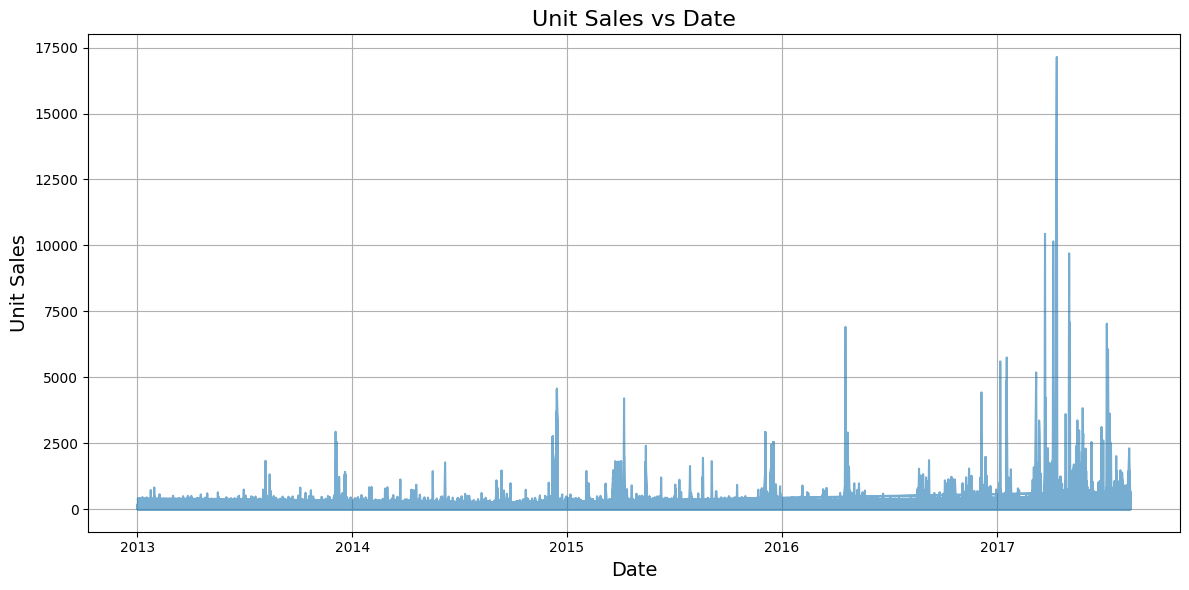

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [ ]:
# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
print('The filled shape is',df_filled.shape)
print('the length of uniques dates', len(df_filled['date'].unique()))

# plot unit_sales vs date
plt.figure(figsize=(12, 6))
plt.plot(df_filled['date'], df_filled['unit_sales'], alpha=0.6)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Unit Sales', fontsize=14)
plt.title('Unit Sales vs Date', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
df_filled.head(5)


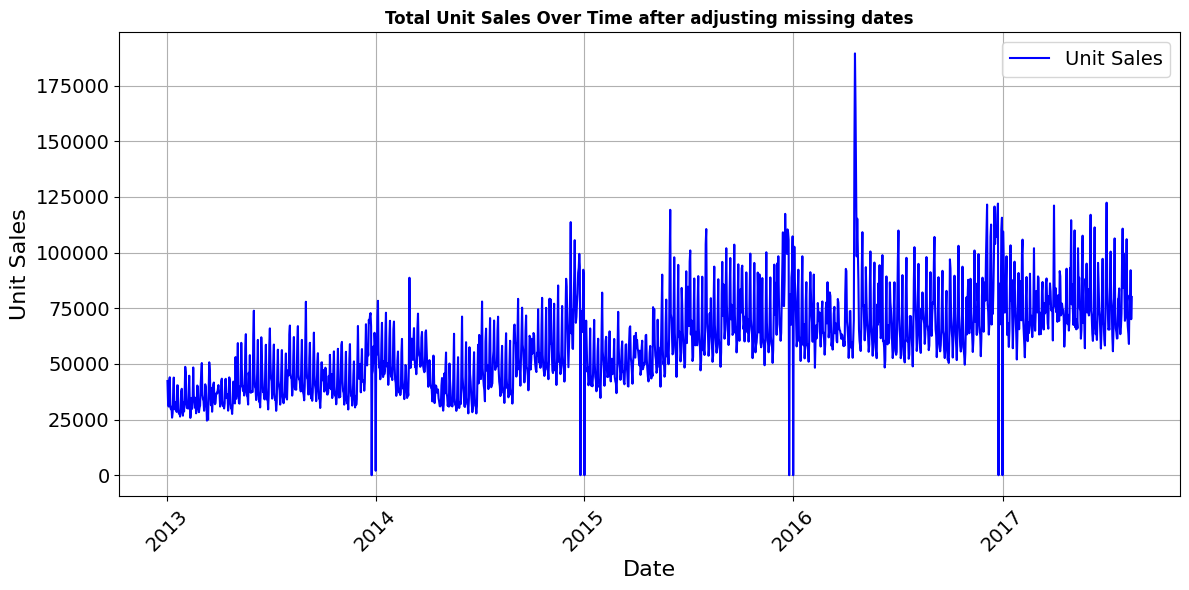

In [ ]:
# Aggregating total unit_sales by date
df_filled_= df_filled.copy()
df_filled_['date'] = pd.to_datetime(df_filled_['date'])
sales_by_date_ = df_filled_.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date_.index, sales_by_date_.values, label='Unit Sales', color='blue')
plt.title('Total Unit Sales Over Time after adjusting missing dates', fontsize=12, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

**The chart shows** total unit sales over time after filling in missing holiday dates.
Sales drop to zero on holidays like Christmas and New Year’s, reflecting store closures, but the overall seasonal and upward trends in sales remain intact.

In [ ]:
print(df_filled.isnull().sum())

store_nbr             0
item_nbr              0
date                  0
id             20323588
unit_sales            0
onpromotion    20323588
dtype: int64


In [ ]:
df_filled_null_id = df_filled[df_filled['id'].isna()]
df_filled_null_id.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
22,24,105574,2013-01-24,NaN,0.0,NaN
34,24,105574,2013-02-05,NaN,0.0,NaN
39,24,105574,2013-02-10,NaN,0.0,NaN
40,24,105574,2013-02-11,NaN,0.0,NaN
41,24,105574,2013-02-12,NaN,0.0,NaN


In [ ]:
df_filled_null_onpromotion = df_filled[df_filled['onpromotion'].isna()]
df_filled_null_onpromotion.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
22,24,105574,2013-01-24,NaN,0.0,NaN
34,24,105574,2013-02-05,NaN,0.0,NaN
39,24,105574,2013-02-10,NaN,0.0,NaN
40,24,105574,2013-02-11,NaN,0.0,NaN
41,24,105574,2013-02-12,NaN,0.0,NaN


In [ ]:
# filling null values in onpromotion column with 0
df_filled['onpromotion'] = df_filled['onpromotion'].fillna(0).astype(int)
print('unique count\n',df_filled.nunique())
print('shape\n',df_filled.shape)
print('null value\n',df_filled.isnull().sum())
print(df_filled['onpromotion'].value_counts())


unique count
 store_nbr            11
item_nbr           2323
date               1687
id             14745768
unit_sales         4467
onpromotion           2
dtype: int64
shape
 (35069356, 6)
null value
 store_nbr             0
item_nbr              0
date                  0
id             20323588
unit_sales            0
onpromotion           0
dtype: int64
onpromotion
0    34390059
1      679297
Name: count, dtype: int64


In [ ]:
# Perform the merge : outliers dataset with df_filled dataset
import pandas as pd
# Convert date columns to datetime
df_filled['date'] = pd.to_datetime(df_filled['date'])
outliers['date'] = pd.to_datetime(outliers['date'])
merged_df_filled_outlier = pd.merge(
    df_filled,
    outliers,
    on=['store_nbr', 'id', 'item_nbr', 'unit_sales', 'date','onpromotion'],
    how='left'
)

# Display the result
print('The merged DataFrame shape is:', merged_df_filled_outlier.shape)
merged_df_filled_outlier.drop(columns=['z_scores'], inplace=True)
# 
merged_df_filled_outlier.head()

/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_22795/3876302833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['date'] = pd.to_datetime(outliers['date'])


The merged DataFrame shape is: (35069356, 8)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier
0,24,105574,2013-01-02,18790.0,12.0,0,NaN
1,24,105574,2013-01-03,59692.0,1.0,0,NaN
2,24,105574,2013-01-04,99664.0,3.0,0,NaN
3,24,105574,2013-01-05,140805.0,4.0,0,NaN
4,24,105574,2013-01-06,182800.0,7.0,0,NaN


In [ ]:
print('shape\n',merged_df_filled_outlier.shape)
print('null\n', merged_df_filled_outlier.isnull().sum())
print('duplicates \n', merged_df_filled_outlier.duplicated().sum())
print('value counts\n',merged_df_filled_outlier['outlier'].value_counts())
print(merged_df_filled_outlier['onpromotion'].value_counts())

shape
 (35069356, 7)
null
 store_nbr             0
item_nbr              0
date                  0
id             20323588
unit_sales            0
onpromotion           0
outlier        35020871
dtype: int64
duplicates 
 0
value counts
 outlier
1.0    48485
Name: count, dtype: int64
onpromotion
0    34390059
1      679297
Name: count, dtype: int64


## **5. Merging full-range-date dataset with outliers,oil price,transactions & holiday**

In [ ]:
# Fill NaN values in merged_df_filled_outlier dataset in the 'outlier' column with 0
merged_df_filled_outlier['outlier'] = merged_df_filled_outlier['outlier'].fillna(0).astype(int)
print(merged_df_filled_outlier.isnull().sum())
merged_df_filled_outlier['outlier'].value_counts()

store_nbr             0
item_nbr              0
date                  0
id             20323588
unit_sales            0
onpromotion           0
outlier               0
dtype: int64


outlier
0    35020871
1       48485
Name: count, dtype: int64

In [ ]:
zero_saless=merged_df_filled_outlier[merged_df_filled_outlier['unit_sales']==0]
print(len(zero_saless))
zero_saless.head(5) # because of return and also from all possible combination dates

20324382


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier
22,24,105574,2013-01-24,NaN,0.0,0,0
34,24,105574,2013-02-05,NaN,0.0,0,0
39,24,105574,2013-02-10,NaN,0.0,0,0
40,24,105574,2013-02-11,NaN,0.0,0,0
41,24,105574,2013-02-12,NaN,0.0,0,0


In [ ]:
# Perform the merge
merged_outlier_oil = pd.merge(merged_df_filled_outlier, df_oil, on='date', how='left')

# Display the result
print('The merged DataFrame shape is:', merged_outlier_oil.shape)
merged_outlier_oil.head()

The merged DataFrame shape is: (35069356, 8)


,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.14
1,24,105574,2013-01-03,59692.0,1.0,0,0,92.97
2,24,105574,2013-01-04,99664.0,3.0,0,0,93.12
3,24,105574,2013-01-05,140805.0,4.0,0,0,NaN
4,24,105574,2013-01-06,182800.0,7.0,0,0,NaN


In [ ]:
merged_outlier_oil.isnull().sum()

store_nbr             0
item_nbr              0
date                  0
id             20323588
unit_sales            0
onpromotion           0
outlier               0
dcoilwtico     10019816
dtype: int64

In [ ]:
# Fill NaN values in 'dcoilwtico' column using linear interpolation method
merged_outlier_oil['dcoilwtico'] = merged_outlier_oil['dcoilwtico'].interpolate(method='linear', limit_direction='both')

# Check for any remaining NaN values
print(merged_outlier_oil['dcoilwtico'].isnull().sum())

0


In [ ]:
merged_with_transactions = pd.merge(merged_outlier_oil, df_transactions_guayas, on=['store_nbr', 'date'], how='left')


In [ ]:
merged_with_transactions.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.140000,2605.0
1,24,105574,2013-01-03,59692.0,1.0,0,0,92.970000,2462.0
2,24,105574,2013-01-04,99664.0,3.0,0,0,93.120000,2607.0
3,24,105574,2013-01-05,140805.0,4.0,0,0,93.146667,2578.0
4,24,105574,2013-01-06,182800.0,7.0,0,0,93.173333,2061.0


In [ ]:
print('The merged DataFrame shape is:', merged_with_transactions.shape)

The merged DataFrame shape is: (35069356, 9)


In [ ]:
# Fill NaN values in the 'transactions' column with 0
merged_with_transactions['transactions'] = merged_with_transactions['transactions'].fillna(0).astype(int)

# Verify if there are any remaining NaN values
print(merged_with_transactions['transactions'].isnull().sum())

0


In [ ]:
filtered_holidays_guayas['date'] = pd.to_datetime(df_holiday['date'])

/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_22795/2449965857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_holidays_guayas['date'] = pd.to_datetime(df_holiday['date'])


In [ ]:
print('The filtered_holidays_guayas shape is',filtered_holidays_guayas.shape)
print('the unique dates are',len(filtered_holidays_guayas['date'].unique()))
filtered_holidays_guayas

The filtered_holidays_guayas shape is (191, 8)
the unique dates are 183


,date,type,locale,locale_name,description,transferred,is_holiday,is_event
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,1,0
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,0,0
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,1,0
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False,1,0
...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1,0
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1,0
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1,0
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1,0


In [ ]:
# Find dates that appear more than once
duplicate_dates = filtered_holidays_guayas['date'].value_counts()
duplicate_dates = duplicate_dates[duplicate_dates > 1].index

# Filter the dataset for those dates
filtered_holidays_guayas_duplicates = filtered_holidays_guayas[filtered_holidays_guayas['date'].isin(duplicate_dates)]
filtered_holidays_guayas_duplicates

,date,type,locale,locale_name,description,transferred,is_holiday,is_event
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False,1,0
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False,1,0
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False,1,0
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False,1,0
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False,1,0
157,2014-12-26,Additional,National,Ecuador,Navidad+1,False,1,0
235,2016-05-01,Holiday,National,Ecuador,Dia del Trabajo,False,1,0
236,2016-05-01,Event,National,Ecuador,Terremoto Manabi+15,False,0,1
242,2016-05-07,Additional,National,Ecuador,Dia de la Madre-1,False,1,0
243,2016-05-07,Event,National,Ecuador,Terremoto Manabi+21,False,0,1


In [ ]:
# Group by 'date' and check for duplicates
def correct_holidays(group):
    if len(group) > 1:
        if group['is_holiday'].nunique() == 1:  # All 'is_holiday' values are the same
            return group.iloc[:1]  # Keep only the first row
        else:  # Different 'is_holiday' values
            group = group.iloc[:1]  # Keep only the first row
            group['is_holiday'] = 1
            group['is_event'] = 1
            return group
    return group

filtered_holidays_guayas_corrected = (
    filtered_holidays_guayas.groupby('date', group_keys=False).apply(correct_holidays)
)

filtered_holidays_guayas_corrected.reset_index(drop=True, inplace=True)
filtered_holidays_guayas_corrected

/var/folders/hj/bjtkr_b13175_g6c53_yly7c0000gn/T/ipykernel_22795/1753569996.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_holidays_guayas.groupby('date', group_keys=False).apply(correct_holidays)


,date,type,locale,locale_name,description,transferred,is_holiday,is_event
0,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
1,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False,1,0
2,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,0,0
3,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False,1,0
4,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False,1,0
...,...,...,...,...,...,...,...,...
178,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1,0
179,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1,0
180,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1,0
181,2017-12-25,Holiday,National,Ecuador,Navidad,False,1,0


In [ ]:
filtered_holidays_guayas_corrected['date'].nunique()

183

In [ ]:
filtered_holidays_guayas_corrected[
    (filtered_holidays_guayas_corrected['is_holiday'] == 1) &
    (filtered_holidays_guayas_corrected['is_event'] == 1)
]

,date,type,locale,locale_name,description,transferred,is_holiday,is_event
124,2016-05-01,Holiday,National,Ecuador,Dia del Trabajo,False,1,1
130,2016-05-07,Additional,National,Ecuador,Dia de la Madre-1,False,1,1


In [ ]:
holidays_event_guayas_state=filtered_holidays_guayas_corrected[['date', 'is_holiday', 'is_event']]
#holidays_event_guayas_state

In [ ]:
# Perform the merge
merged_with_holidays = pd.merge(merged_with_transactions, holidays_event_guayas_state, on='date', how='left')



In [ ]:
merged_with_holidays.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,is_event
0,24,105574,2013-01-02,18790.0,12.0,0,0,93.140000,2605,NaN,NaN
1,24,105574,2013-01-03,59692.0,1.0,0,0,92.970000,2462,NaN,NaN
2,24,105574,2013-01-04,99664.0,3.0,0,0,93.120000,2607,NaN,NaN
3,24,105574,2013-01-05,140805.0,4.0,0,0,93.146667,2578,0.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0,0,93.173333,2061,NaN,NaN


In [ ]:
print('the shape of merged_with_holidays is',merged_with_holidays.shape)

the shape of merged_with_holidays is (35069356, 11)


In [ ]:
print('the null value is',merged_with_holidays.isnull().sum())

the null value is store_nbr              0
item_nbr               0
date                   0
id              20323588
unit_sales             0
onpromotion            0
outlier                0
dcoilwtico             0
transactions           0
is_holiday      31743276
is_event        31743276
dtype: int64


In [ ]:
# Fill NaN values in 'is_holiday' and 'is_event' columns with 0
merged_with_holidays['is_holiday'] = merged_with_holidays['is_holiday'].fillna(0).astype(int)
merged_with_holidays['is_event'] = merged_with_holidays['is_event'].fillna(0).astype(int)

# Verify if there are any remaining NaN values
print(merged_with_holidays[['is_holiday', 'is_event']].isnull().sum())

is_holiday    0
is_event      0
dtype: int64


In [ ]:
from IPython.display import FileLink

# Save the dataset as a CSV file
#merged_with_holidays.to_csv('merged_dataset.csv', index=False)

# Provide a link to download the file (for Jupyter Notebook)
#FileLink('merged_dataset.csv')

## 6. **EDA**

Now we have all dates and corresponding sales for them. Let's replace the original dataframe:

In [ ]:
df_train = df_filled
del df_filled


In [ ]:
df_train.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0
1,24,105574,2013-01-03,59692.0,1.0,0
2,24,105574,2013-01-04,99664.0,3.0,0
3,24,105574,2013-01-05,140805.0,4.0,0
4,24,105574,2013-01-06,182800.0,7.0,0


### **1. Time based Features to see sales over the time**

In [ ]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

In [ ]:
# Calculating rolling average of unit_sales 7 days
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())
# Calculating rolling average of unit_sales 30 days
df_train['unit_sales_30d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=30).mean())
df_train.tail(10)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,unit_sales_30d_avg
35069346,51,2123791,2017-08-06,NaN,0.0,0,2017,8,6,6,0.000000,0.000000
35069347,51,2123791,2017-08-07,NaN,0.0,0,2017,8,7,0,0.000000,0.000000
35069348,51,2123791,2017-08-08,NaN,0.0,0,2017,8,8,1,0.000000,0.000000
35069349,51,2123791,2017-08-09,NaN,0.0,0,2017,8,9,2,0.000000,0.000000
35069350,51,2123791,2017-08-10,NaN,0.0,0,2017,8,10,3,0.000000,0.000000
35069351,51,2123791,2017-08-11,NaN,0.0,0,2017,8,11,4,0.000000,0.000000
35069352,51,2123791,2017-08-12,NaN,0.0,0,2017,8,12,5,0.000000,0.000000
35069353,51,2123791,2017-08-13,NaN,0.0,0,2017,8,13,6,0.000000,0.000000
35069354,51,2123791,2017-08-14,NaN,0.0,0,2017,8,14,0,0.000000,0.000000
35069355,51,2123791,2017-08-15,125491523.0,1.0,0,2017,8,15,1,0.142857,0.033333


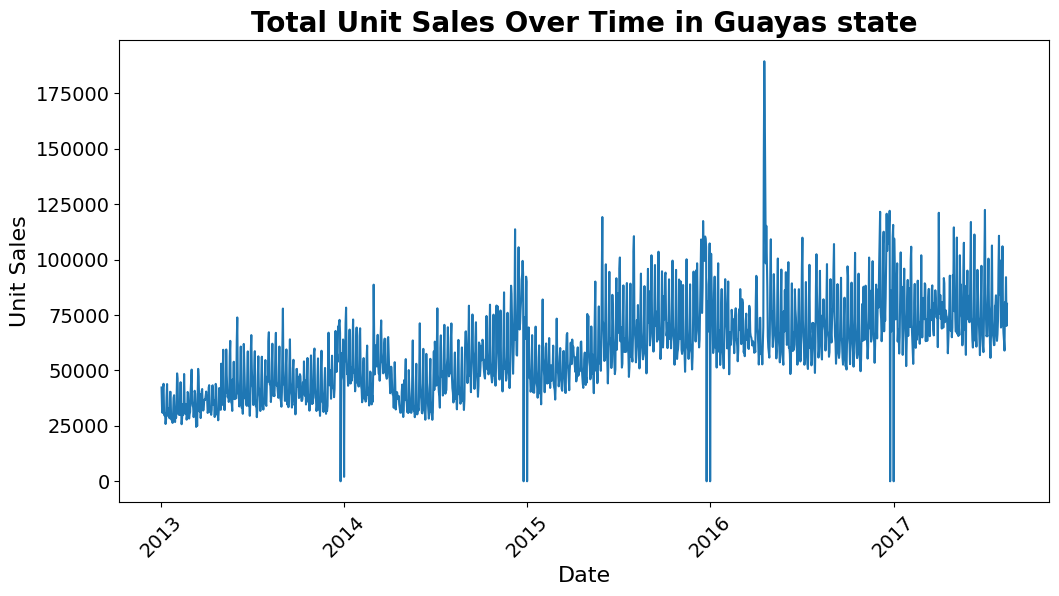

In [ ]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

**The chart shows total unit sales in Guayas state from 2013 to 2017.**

**•	General Pattern:**

Sales show a gradual upward trend over the years with regular fluctuations, likely reflecting seasonality, promotions, and holidays.
Periodic sharp drops to zero correspond to major holidays when stores were closed (e.g., Christmas, New Year’s).

**•	April 2016 Spike:**

There’s a pronounced spike in April 2016. This surge was caused by emergency relief sales following the Ecuador earthquake, when demand for essential goods dramatically increased.

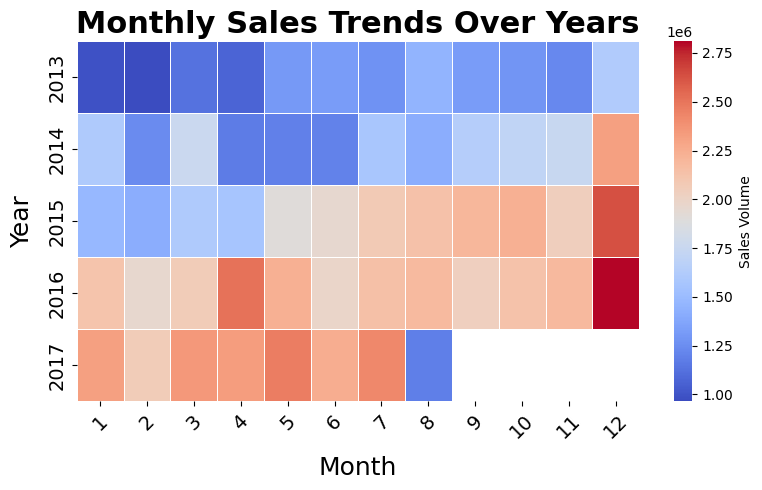

In [ ]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

**This heatmap shows monthly sales trends from 2013 to 2017.**

**Key observations:**

•	2013–2014: Sales volumes were relatively low and stable, with slight increases in December, likely due to holiday shopping.

•	2015: Sales picked up, with stronger performance in the second half of the year, peaking in December.

•	2016: Overall sales volume rose significantly compared to previous years. April saw a big increase (earthquake relief demand), and December recorded the highest sales of all years.

•	2017: Sales remained high in the first eight months but dropped sharply in September, possibly due to missing or incomplete data for the last months.

General pattern: December consistently shows the highest sales, reflecting seasonal holiday demand, while early months tend to have lower volumes.

### **2. Impact of Holidays on Sales**

In [ ]:
# Convert date column to datetime
df_holiday['date'] = pd.to_datetime(df_holiday['date'])
print("Holidays range: from",df_holiday['date'].dt.date.min(),"till",df_holiday['date'].dt.date.max())

Holidays range: from 2012-03-02 till 2017-12-26


In [ ]:
df_train_no_zero_sales = df_train[df_train['unit_sales'] > 0]

: 

In [ ]:
# Merging df_train with zero sales with data with holidays
df_train_holiday = pd.merge(df_train_no_zero_sales, df_holiday, on='date', how='left')


In [ ]:
df_train_holiday

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,unit_sales_30d_avg,type,locale,locale_name,description,transferred,is_holiday,is_event
0,24,105574,2013-01-02,18790.0,12.0,0.0,2013,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24,105574,2013-01-03,59692.0,1.0,0.0,2013,1,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24,105574,2013-01-04,99664.0,3.0,0.0,2013,1,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24,105574,2013-01-05,140805.0,4.0,0.0,2013,1,5,5,NaN,NaN,Work Day,National,Ecuador,Recupero puente Navidad,False,0.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0,2013,1,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15032306,29,2122868,2017-08-15,125447370.0,1.0,0.0,2017,8,15,1,0.142857,0.033333,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1.0,0.0
15032307,29,2123839,2017-08-15,125447372.0,6.0,0.0,2017,8,15,1,0.857143,0.200000,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1.0,0.0
15032308,51,2123750,2017-08-15,125491521.0,3.0,0.0,2017,8,15,1,0.428571,0.100000,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1.0,0.0
15032309,51,2123775,2017-08-15,125491522.0,1.0,0.0,2017,8,15,1,0.142857,0.033333,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1.0,0.0


In [ ]:
df_train_holiday['store_nbr'].unique().tolist()

[24, 26, 27, 28, 30, 32, 34, 35, 51, 36, 29]

In [ ]:
df_train_holiday.isnull().sum()

store_nbr                    0
item_nbr                     0
date                         0
id                           0
unit_sales                   0
onpromotion                  0
year                         0
month                        0
day                          0
day_of_week                  0
unit_sales_7d_avg        29995
unit_sales_30d_avg      143269
type                  12488638
locale                12488638
locale_name           12488638
description           12488638
transferred           12488638
is_holiday            12488638
is_event              12488638
dtype: int64

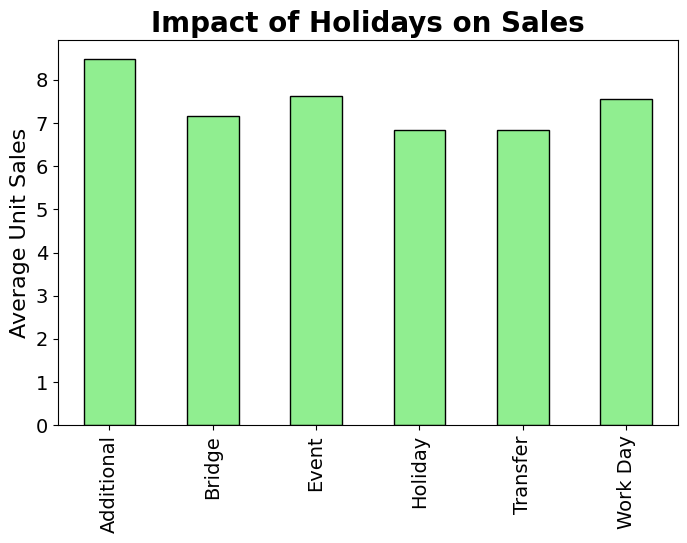

In [ ]:
# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**This bar chart shows the average unit sales for different holiday types.**

**Analysis:**

1.	Highest sales: Additional holidays lead with the highest average unit sales (~8.4).
2.	Above-average sales: Event days and Work Days also show higher-than-normal averages (~7.5–7.6).
3.	Lower sales: Holiday and Transfer days have the lowest averages (~6.8–6.9).
4.	Bridge days are moderate (~7.1).

**Possible reasons:**

1.	Additional holidays (e.g., Christmas Eve) often create extra shopping opportunities before big celebrations, boosting sales.
2.	Events (festivals, public celebrations) tend to increase consumer activity and spending.
3.	Work Days that replace holidays (to balance long weekends) might still be close to holiday seasons, so demand stays high.
4.	Regular Holidays may have lower sales because many businesses are closed, limiting purchase opportunities.
5.	Transfer days might feel like normal weekdays, reducing urgency for shopping.

### **3. Sales impact by oil price**

In [ ]:
import pandas as pd

# If your script is in the same folder as 'data_store_sales'
df = pd.read_csv("data_store_sales/merged_dataset.csv")

# Show first few rows
print(df.head())

   store_nbr  item_nbr        date        id  unit_sales  onpromotion  \
0         24    105574  2013-01-02   18790.0        12.0            0   
1         24    105574  2013-01-03   59692.0         1.0            0   
2         24    105574  2013-01-04   99664.0         3.0            0   
3         24    105574  2013-01-05  140805.0         4.0            0   
4         24    105574  2013-01-06  182800.0         7.0            0   

   outlier  dcoilwtico  transactions  is_holiday  is_event  
0        0   93.140000          2605           0         0  
1        0   92.970000          2462           0         0  
2        0   93.120000          2607           0         0  
3        0   93.146667          2578           0         0  
4        0   93.173333          2061           0         0  


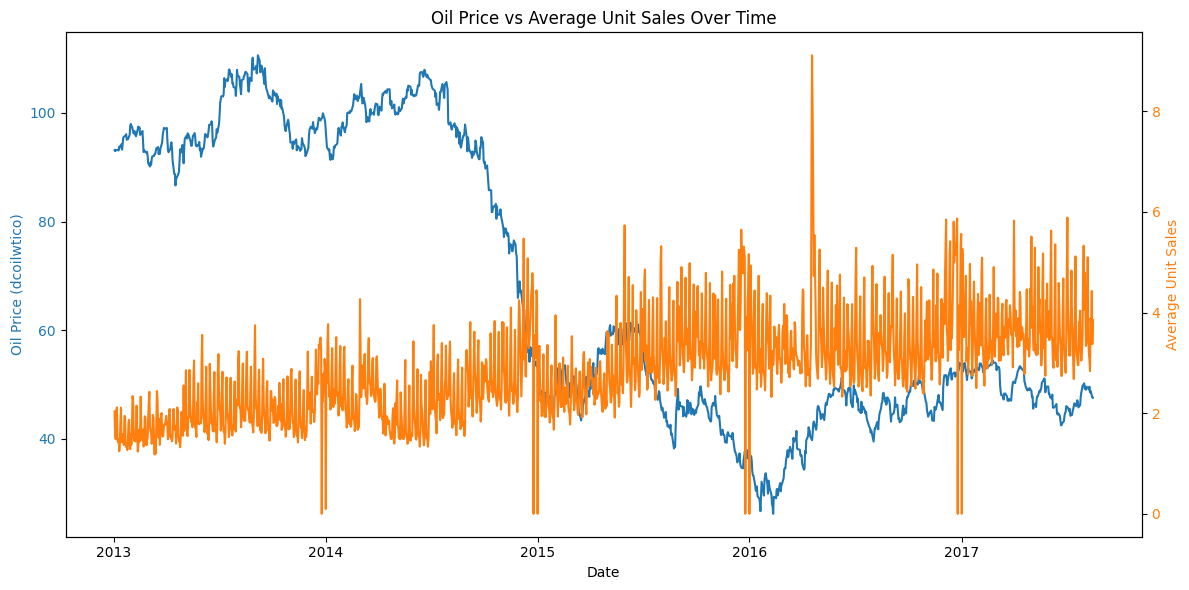

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your merged_dataset DataFrame
df['date'] = pd.to_datetime(df['date'])

# Group by date to get average sales
daily_data = df.groupby('date').agg({
    'unit_sales': 'mean',
    'dcoilwtico': 'mean'
}).reset_index()

# Create plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Oil Price
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Price (dcoilwtico)', color='tab:blue')
ax1.plot(daily_data['date'], daily_data['dcoilwtico'], color='tab:blue', label='Oil Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis for Unit Sales
ax2 = ax1.twinx()
ax2.set_ylabel('Average Unit Sales', color='tab:orange')
ax2.plot(daily_data['date'], daily_data['unit_sales'], color='tab:orange', label='Avg Unit Sales')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and layout
plt.title('Oil Price vs Average Unit Sales Over Time')
fig.tight_layout()
plt.show()

**Summary & Findings**

1.	Oil Price Trend (Blue Line):

From 2013 to mid-2014, oil prices stayed above $90, peaking above $100.
Starting late 2014, prices dropped sharply, reaching around $30 in early 2016 before partially recovering.

2.	Average Unit Sales Trend (Orange Line):

Sales show regular fluctuations (seasonality) and a gradual upward trend over the years.
Spikes in sales are noticeable, especially around mid-2016, possibly tied to promotions, holidays, or special events.

3.	Relationship Observation:

The large drop in oil prices from 2014–2016 doesn’t show a direct mirrored drop in average unit sales — suggesting that oil price changes might not have a strong immediate effect on sales volumes in this dataset.
However, certain peaks in sales occur when oil prices are low, which could indicate improved consumer purchasing power during low fuel cost periods.

### **4. Sales impact by Perishable items**

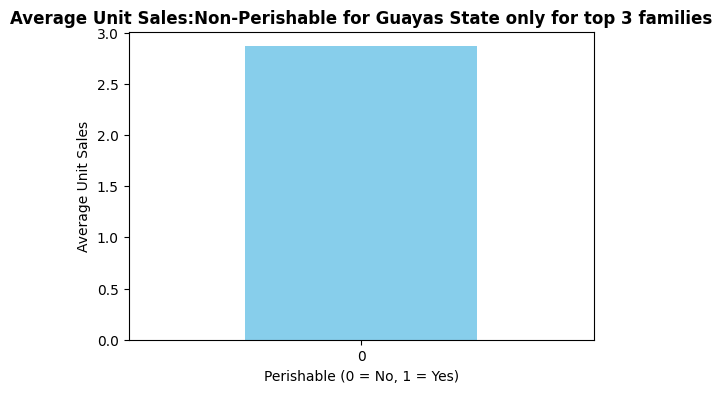

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Merge datasets on 'item_nbr'
merged_df = pd.merge(df, df_items, on='item_nbr', how='left')

# Group by perishable and calculate average unit sales
perishable_sales = merged_df.groupby('perishable')['unit_sales'].mean()

# Plot
plt.figure(figsize=(6,4))
perishable_sales.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Average Unit Sales:Non-Perishable for Guayas State only for top 3 families', fontsize=12, fontweight='bold')
plt.xlabel('Perishable (0 = No, 1 = Yes)')
plt.ylabel('Average Unit Sales')
plt.xticks(rotation=0)
plt.show()

**Average unit sales for non perishable items (top 3 families like grocery I, Beverages and Cleaning) are less than 3 for Guayas State.**

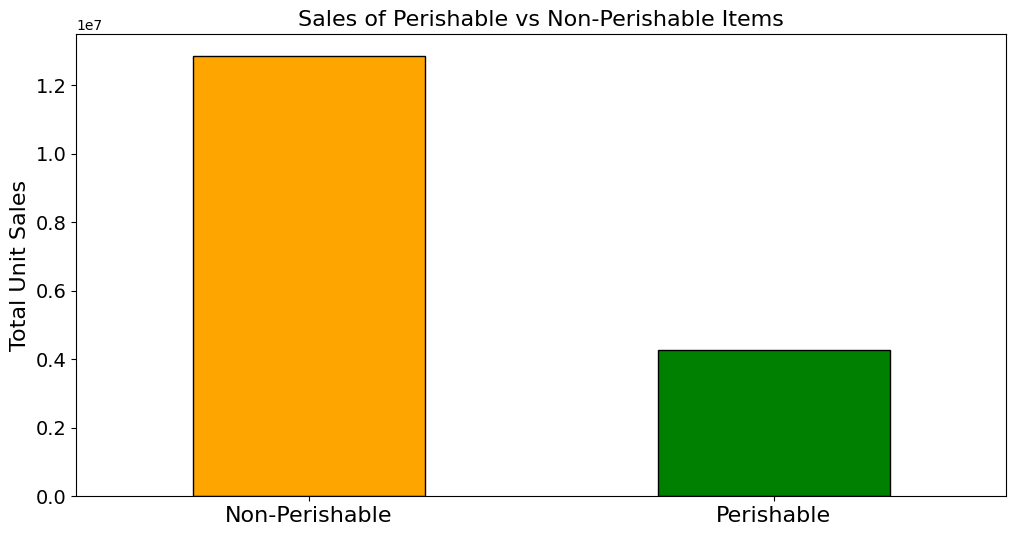

**Perishable items have significantly lower sales volume, even though they may have higher turnover due to shorter shelf life.**

**Business Impact**

1.	Forecasting Importance

	•	Since non-perishables dominate sales, forecast accuracy for these items will have the greatest impact on total revenue.

	•	However, perishable sales forecasting is equally important because overstocking can lead to waste and losses, while understocking causes missed sales.

2.	Inventory & Supply Chain Strategy

	•	Non-perishables → Longer shelf life allows for bulk stocking and slower replenishment cycles.

	•	Perishables → Need short-term, high-accuracy forecasts to avoid spoilage.

3.	Seasonality & Promotion

	•	Perishable items are more sensitive to seasonal changes, holidays, and local events.

	•	Non-perishable demand may be more stable but can spike with promotions or economic changes.

4.	Sales Forecasting Models

	•	Might need separate models for perishable and non-perishable categories.

	•	Perishable forecasts should use shorter time horizons and incorporate weather, holidays, and events.
    
	•	Non-perishable forecasts can use longer-term trends.

### **5. Store vs Item sales analysis**


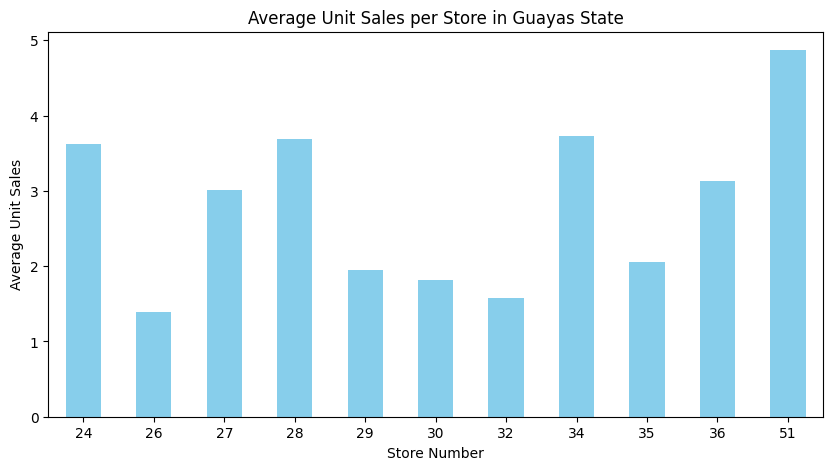

In [72]:
import matplotlib.pyplot as plt

# Group by store_nbr and calculate average unit_sales
avg_sales_per_store = df.groupby('store_nbr')['unit_sales'].mean()

# Plot
plt.figure(figsize=(10,5))
avg_sales_per_store.plot(kind='bar', color='skyblue')
plt.title('Average Unit Sales per Store in Guayas State')
plt.xlabel('Store Number')
plt.ylabel('Average Unit Sales')
plt.xticks(rotation=0)
plt.show()

**This chart shows average unit sales per store in the Guayas state.**

**Key Observations**

	1.	Store 51 stands out with the highest average unit sales (~4.9 units), well above other stores.
	2.	Stores 28, 34, and 24 also perform relatively well (around 3.6–3.8 units average).
	3.	Stores 26, 32, 30, and 29 are the lowest performers, all averaging under 2 units per sale.
	4.	The gap between the best-performing (Store 51) and the worst-performing (Store 26) is significant — more than 3x difference.

**Possible Business Insights**

	•	High-performing stores (51, 28, 34, 24) could serve as benchmarks to analyze:
	•	Product assortment
	•	Pricing strategies
	•	Promotion effectiveness
	•	Customer demographics
	•	Low-performing stores (26, 32, 30, 29) might need:
	•	Targeted marketing campaigns
	•	Product mix optimization
	•	Store layout or service improvements

**Decision-Making Recommendations**

	1.	Resource Allocation
	•	Allocate more promotional budget to low-performing stores to boost traffic and sales.
	•	Maintain stock priority for high-performing stores to avoid stockouts.
	2.	Performance Gap Analysis
	•	Investigate why Store 51 is so far ahead — location advantage, larger customer base, stronger promotions, etc.
	•	Apply successful practices from Store 51 to underperforming stores.
	3.	Forecasting Implications
	•	Store-level sales forecasting should account for these performance differences — avoid applying a one-size-fits-all model.
	•	Use store-specific parameters to improve prediction accuracy.

In [76]:
df['item_nbr'].nunique()

2323

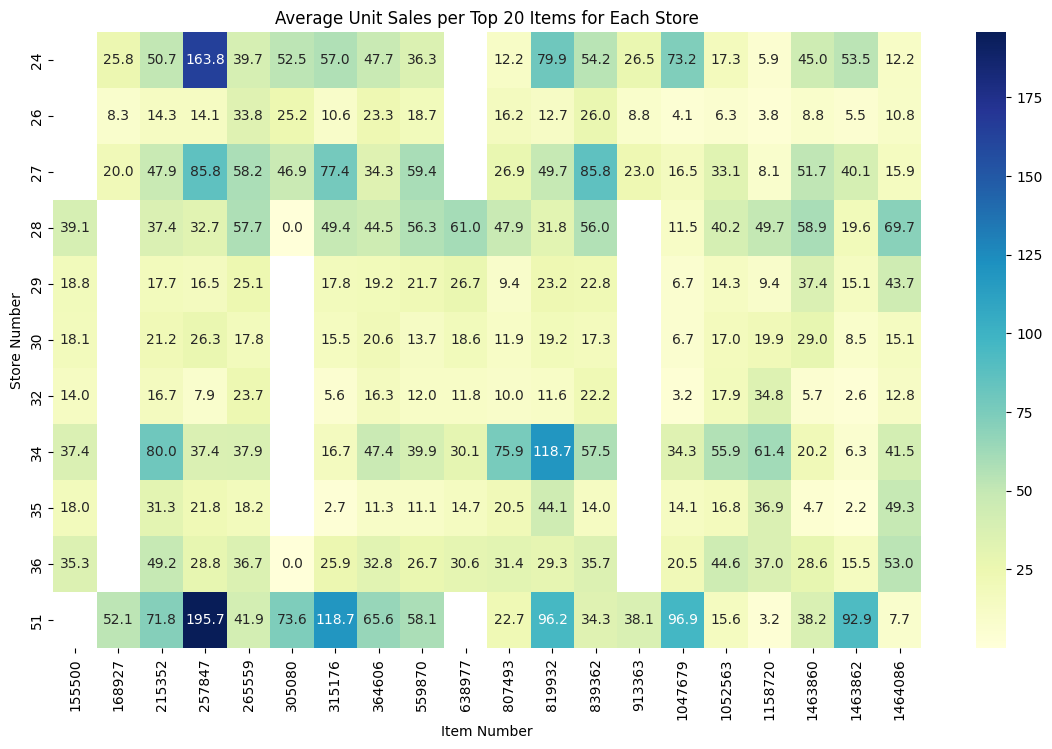

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Find top N items by average unit sales
top_items = (
    df.groupby('item_nbr')['unit_sales']
    .mean()
    .sort_values(ascending=False)
    .head(20)
    .index
)

# Filter to only those items
filtered_df = df[df['item_nbr'].isin(top_items)]

# Group and pivot
avg_sales = filtered_df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].mean().reset_index()
pivot_table = avg_sales.pivot(index='store_nbr', columns='item_nbr', values='unit_sales')

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Average Unit Sales per Top 20 Items for Each Store')
plt.xlabel('Item Number')
plt.ylabel('Store Number')
plt.show()

**This heatmap shows the average unit sales for the top 20 items across different stores in Guayas state.**

**Key **Observations**

	•	High sales concentration:
	•	Store 51 dominates with multiple items selling over 100 units on average (e.g., item 257847 at 195.7 units).
	•	Store 24 also has high-selling items like 163.8 units for item 21532.
	•	Store-specific bestsellers:
	•	Each store has different top items — no single item dominates across all stores.
	•	Low performers:
	•	Stores like 26 and 32 have low average sales across most items, rarely crossing 30 units.

**Business Insights**

**1.	Tailored inventory strategy**
	•	Focus stocking the top-selling items for each store rather than using a uniform product mix.
	•	For example, item 257847 is a huge hit in Store 51 but not in Store 26.

**2.	Targeted promotions**
	•	Push underperforming items in low-sales stores using localized marketing.
	•	Test bundle offers with top items to increase overall basket size.

**3.	Forecasting advantage**
	•	Store-item level data will improve forecasting accuracy by capturing these localized preferences.
	•	Models should use store-item interaction terms instead of just item-level forecasts.
	
**4.	Replication opportunities**
	•	Investigate why items like 21532 and 819932 perform well in certain stores — could be product placement, demographics, or seasonality — and replicate those conditions in other stores.

### **6. Transaction vs Sales unit analysis**

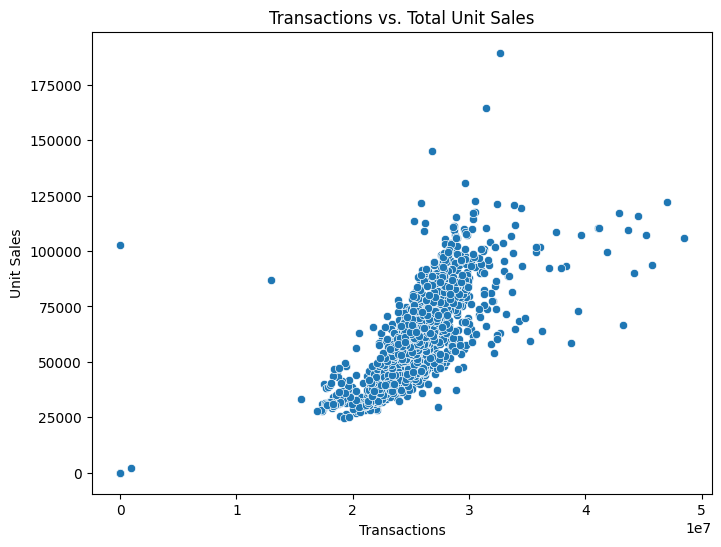

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# 1️⃣ Transactions vs. Total Sales (Correlation)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df.groupby('date')[['transactions','unit_sales']].sum().reset_index(),
                x='transactions', y='unit_sales')
plt.title("Transactions vs. Total Unit Sales")
plt.xlabel("Transactions")
plt.ylabel("Unit Sales")
plt.show()

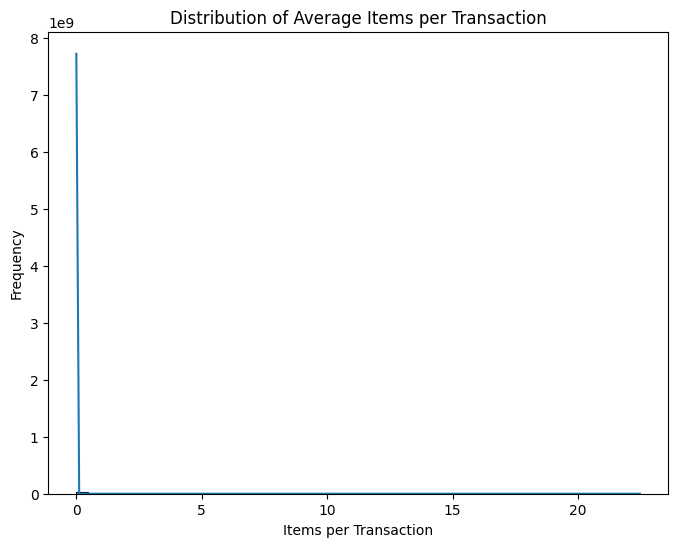

In [127]:
# 2️⃣ Average Items per Transaction
df['avg_items_per_transaction'] = df['unit_sales'] / df['transactions']
plt.figure(figsize=(8,6))
sns.histplot(df['avg_items_per_transaction'], bins=50, kde=True)
plt.title("Distribution of Average Items per Transaction")
plt.xlabel("Items per Transaction")
plt.ylabel("Frequency")
plt.show()

**Short Analysis of Sales volume to transaction number:**

1.	Transactions vs. Unit Sales (Scatter Plot)
	•	There’s a clear positive correlation — stores with more transactions generally have higher total unit sales.
	•	A few outliers exist where transactions are low but sales are unusually high (possibly due to bulk purchases or promotions).
2.	Distribution of Average Items per Transaction
	•	The distribution is heavily right-skewed, with most transactions having very few items per basket.
	•	The extreme values (long tail) could be due to special events, large bulk orders, or data anomalies.

**Business Insight:**

	•	Forecasting models should account for transaction volume as a strong predictor of sales.
	•	The skew in basket size suggests that promotions encouraging multi-item purchases could significantly boost sales.
	•	Outliers should be reviewed — they might indicate special campaigns worth replicating or data entry errors to clean.

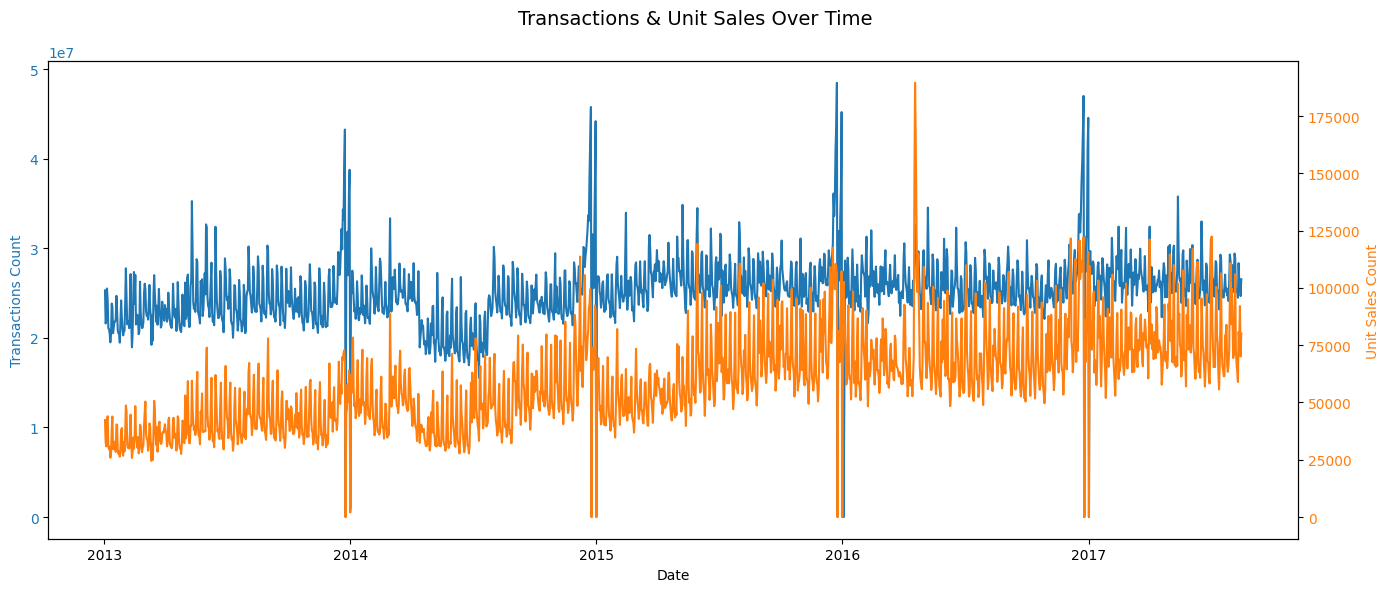

In [129]:
# 3️⃣ Trend Over Time with Dual Axes
daily = df.groupby('date')[['transactions', 'unit_sales']].sum().reset_index()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis - Transactions
color = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("Transactions Count", color=color)
ax1.plot(daily['date'], daily['transactions'], color=color, label='Transactions')
ax1.tick_params(axis='y', labelcolor=color)

# Right axis - Unit Sales
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel("Unit Sales Count", color=color)
ax2.plot(daily['date'], daily['unit_sales'], color=color, label='Unit Sales')
ax2.tick_params(axis='y', labelcolor=color)

# Title & Legends
fig.suptitle("Transactions & Unit Sales Over Time", fontsize=14)
fig.tight_layout()
plt.show()

**This chart compares daily transactions (blue, left axis) and unit sales (orange, right axis) over time for Corporación Favorita in Guayas state.**

**Key observations:**

	•	Both metrics follow a similar seasonal pattern, with peaks likely around holidays or promotional periods.
	•	Noticeable spikes occur at specific times each year, possibly during Christmas/New Year or special sales events.
	•	A few sharp drops to near-zero indicate missing data or store closures (e.g., holidays when stores were closed).
	•	Over the years, there’s a gradual upward trend in both transactions and unit sales, suggesting growing customer traffic and demand.

**Business implication for forecasting:**

	•	Since transactions and unit sales move together, transaction counts could be a predictive feature for sales forecasting.
	•	Seasonal spikes indicate the importance of holiday-specific forecasting models to capture demand surges.

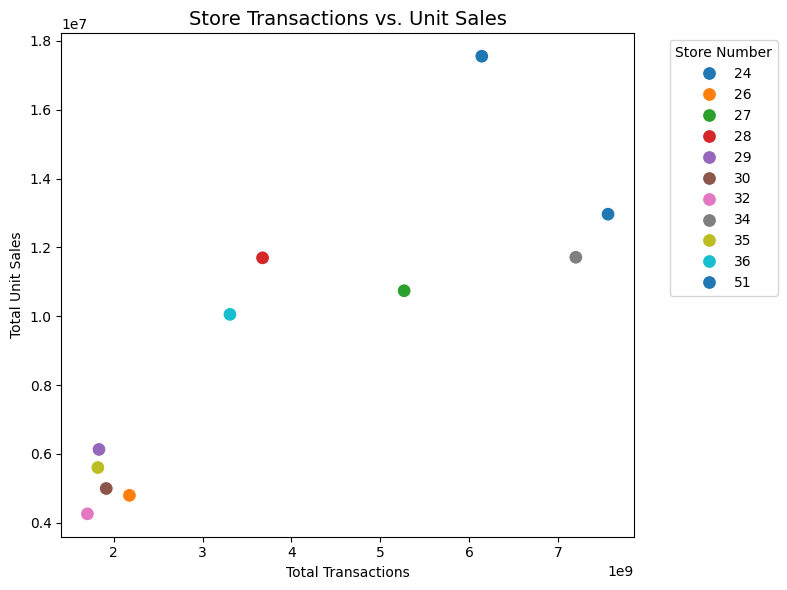

In [131]:
# 4️⃣ Store-Level Analysis with Different Colors
store_stats = df.groupby('store_nbr')[['transactions', 'unit_sales']].sum().reset_index()

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=store_stats,
    x='transactions',
    y='unit_sales',
    hue='store_nbr',           # Color by store number
    palette='tab10',           # Color palette (good for up to ~10-12 categories)
    s=100                      # Point size
)

plt.title("Store Transactions vs. Unit Sales", fontsize=14)
plt.xlabel("Total Transactions")
plt.ylabel("Total Unit Sales")
plt.legend(title='Store Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Short Analysis of sales volume per transaction at each store:**

	•	Store 24 and 51 have the highest total unit sales and transactions, indicating they are top-performing locations.
	•	Stores 27, 28, 34 also perform well but with lower transaction counts compared to the top two, suggesting higher basket sizes or more premium items.
	•	Stores 26, 29, 30, 32, 35, 36 have significantly lower sales and transaction volumes, pointing to either smaller customer bases, less effective promotions, or location disadvantages.

**Decision & Recommendations:**

1.	Focus on High Performers (24, 51): Maintain inventory efficiency, ensure no stockouts, and test premium product offerings to maximize revenue.
2.	Mid-Tier Growth (27, 28, 34): Targeted promotions and localized campaigns could help boost transactions to match top performers.
3.	Low Performers (26, 29, 30, 32, 35, 36):
	•	Investigate causes — location, competition, store size, or assortment.
	•	Consider special discounts, product mix adjustments, or community engagement to drive traffic.
	•	If performance doesn’t improve, assess long-term viability.

### **7.Weekly transaction volume**

<Figure size 800x600 with 0 Axes>

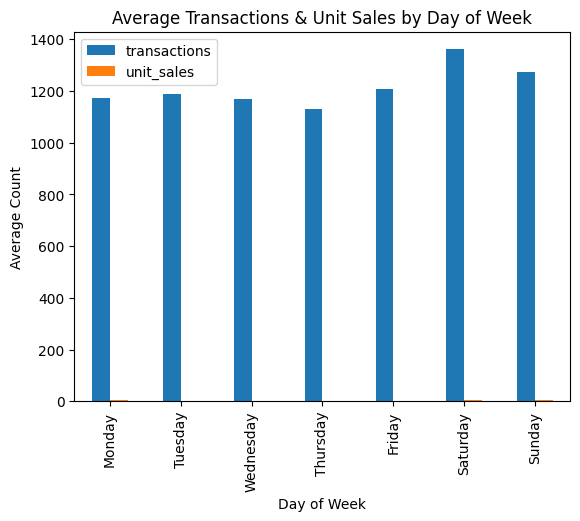

In [124]:
# 5️⃣ Day-of-Week Patterns
df['day_of_week'] = df['date'].dt.day_name()
dow_stats = df.groupby('day_of_week')[['transactions','unit_sales']].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
plt.figure(figsize=(8,6))
dow_stats.plot(kind='bar')
plt.title("Average Transactions & Unit Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Count")
plt.show()

**Short Analysis:**

	•	Saturday has the highest average transactions, indicating it’s the busiest day for Corporación Favorita.
	•	Sunday also sees high customer traffic, likely due to weekend shopping habits.
	•	Thursday is the slowest day, with the lowest transactions.
	•	The unit_sales bars are barely visible because their scale is much smaller compared to transactions — suggesting customers may buy only a few items per visit on average.

**Business Insights & Decisions:**

	1.	Weekend Focus: Increase staffing, inventory, and promotions on Saturday and Sunday to maximize sales.
	2.	Boost Slow Days: Introduce mid-week offers or discounts (especially on Thursday) to spread customer visits more evenly.
	3.	Cross-Selling: Since unit sales per transaction are relatively low, train staff or use in-store promotions to encourage multi-item purchases.

### **8.Sales impact by Holiday**

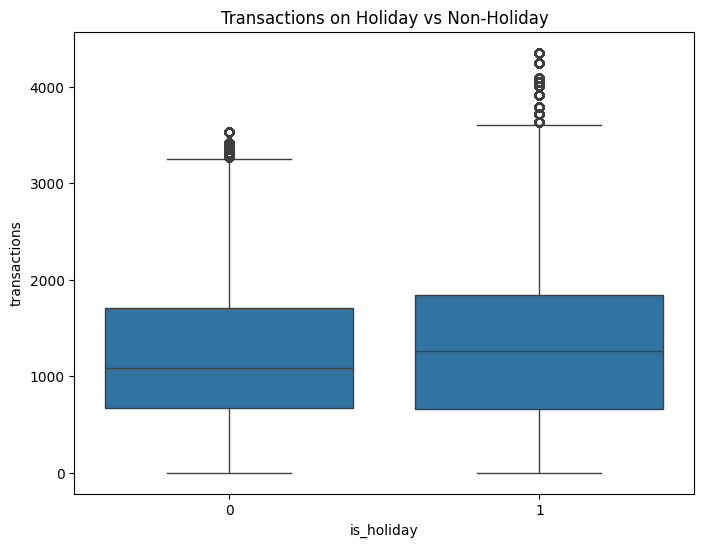

In [125]:
# 6️⃣ Holiday vs Non-Holiday Impact (if you have is_holiday column)
if 'is_holiday' in df.columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=df, x='is_holiday', y='transactions')
    plt.title("Transactions on Holiday vs Non-Holiday")
    plt.show()

**Short Analysis for Guayas states sales impact by holiday :**

	•	The median transaction count is higher on holidays (is_holiday = 1) compared to non-holidays.
	•	The spread of transactions is also wider on holidays, meaning some stores experience very high peaks.
	•	Outliers are more frequent and larger on holidays, showing occasional exceptional spikes in shopping activity.

**Business Insights & Actions:**

	1.	Stock Management: Ensure higher inventory levels before holidays to meet increased demand.
	2.	Staff Planning: Schedule more staff during holidays to handle peak customer flow.
	3.	Promotional Strategy: Use holidays to run targeted promotions, as customers are already in a high-spending mindset.
	4.	Forecast Adjustment: Holiday effects should be explicitly included in sales forecasting models to improve accuracy.

### **9.Busket Size Distribution**


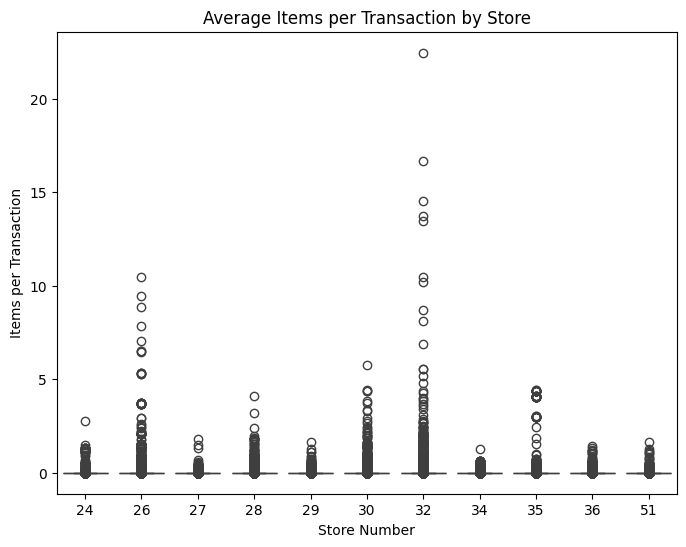

In [126]:
# 7️⃣ Basket Size Distribution
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='store_nbr', y='avg_items_per_transaction')
plt.title("Average Items per Transaction by Store")
plt.xlabel("Store Number")
plt.ylabel("Items per Transaction")
plt.show()

**Short Analysis of average items per transaction by store:**

	•	Most stores have low items per transaction, clustering near 0–1.
	•	Store 32 has unusually high outliers (up to 22 items per transaction), which is significantly above other stores. This may indicate bulk purchasing behavior or a few exceptional events.
	•	Stores 26 and 30 also have moderate high outliers, but far fewer than store 32.

**Business Insights & Actions:**

	1.	Investigate Store 32: Understand why large basket sizes occur — it could be wholesale buyers, special events, or promotions.
	2.	Customer Segmentation: Stores with larger baskets may have more bulk-buying customers; tailor marketing (e.g., bundle discounts) accordingly.
	3.	Stock Allocation: Stores with high basket sizes may require larger product inventory per transaction to avoid stockouts.
	4.	Forecasting Implications: Outlier days in basket size can skew averages; forecasting models should handle these separately.
